# Author Implementation

tol = 0.1


  5%|▌         | 15000/300000 [02:55<55:33, 85.48it/s, Loss=0.0011058804, loss_ics=4.8535535e-06, loss_res=0.00065926387, W_min=0.9935821] 


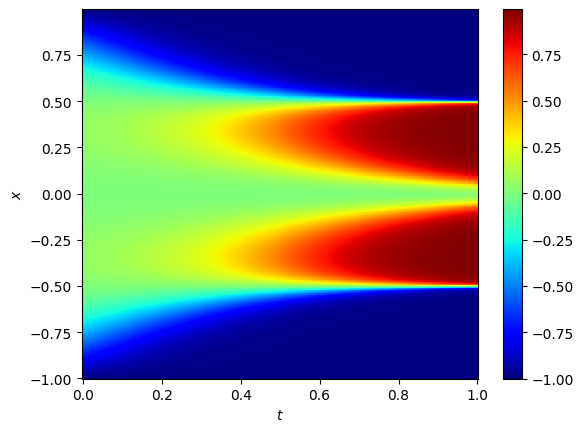

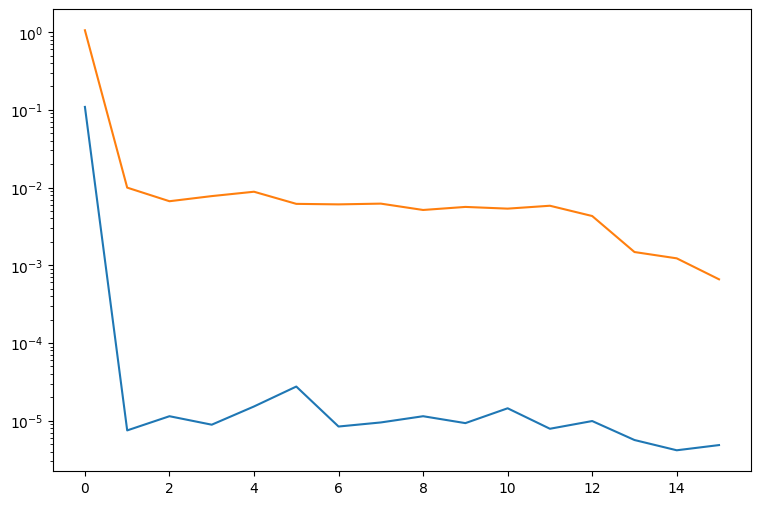

Relative l2 error: 1.641e-01


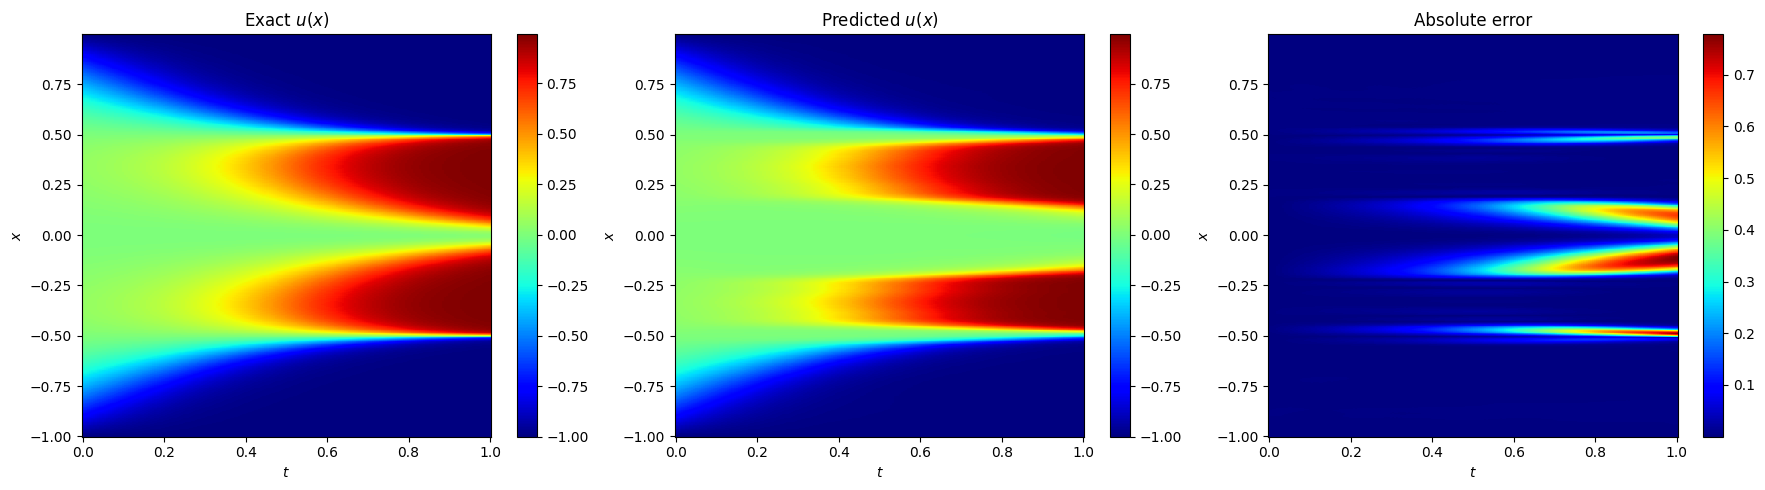

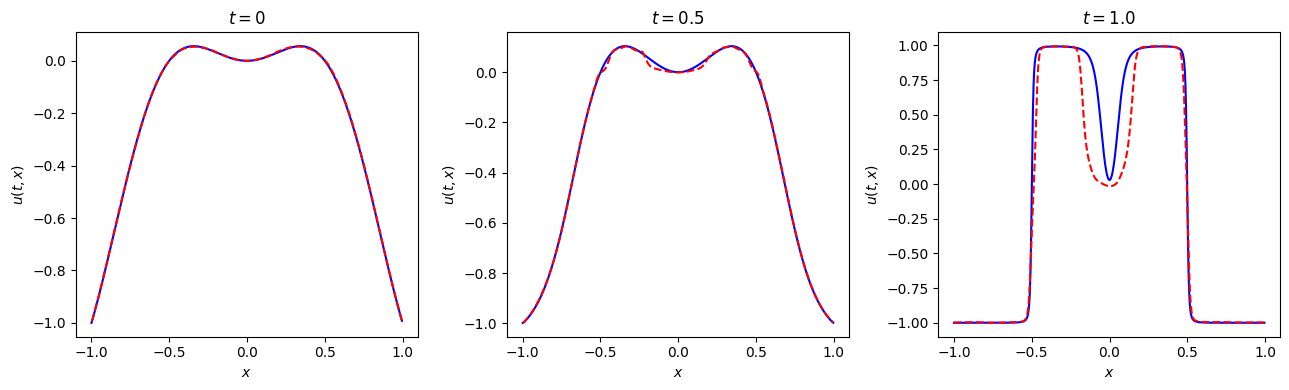

tol = 1.0


  1%|▏         | 4000/300000 [00:43<54:14, 90.94it/s, Loss=0.00019374158, loss_ics=1.0195531e-06, loss_res=9.0440575e-05, W_min=0.9913293]  


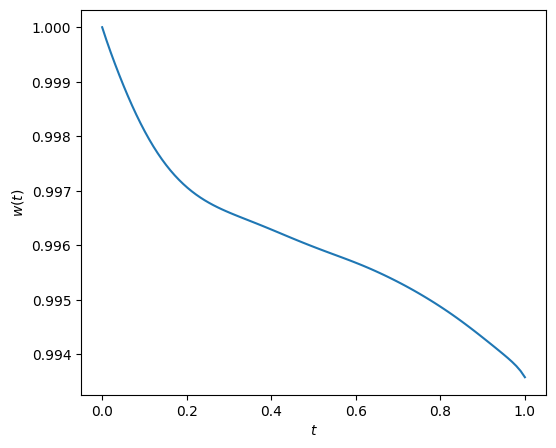

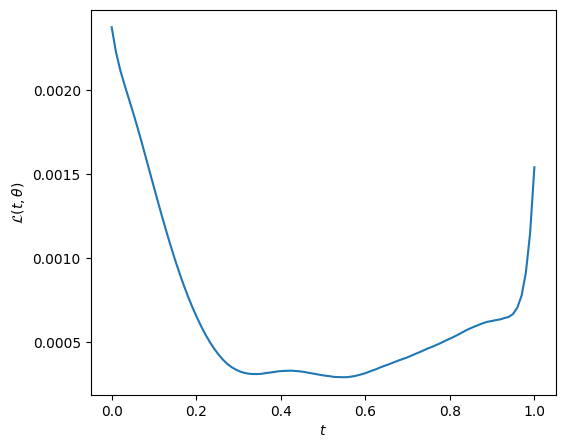

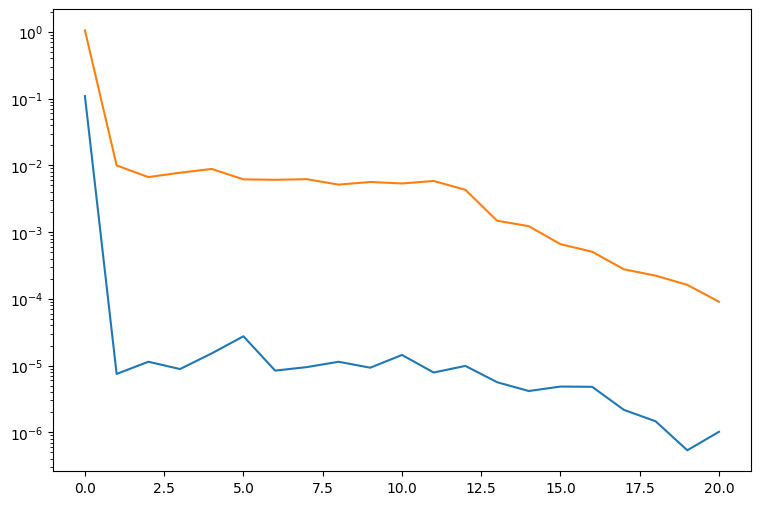

Relative l2 error: 8.354e-02


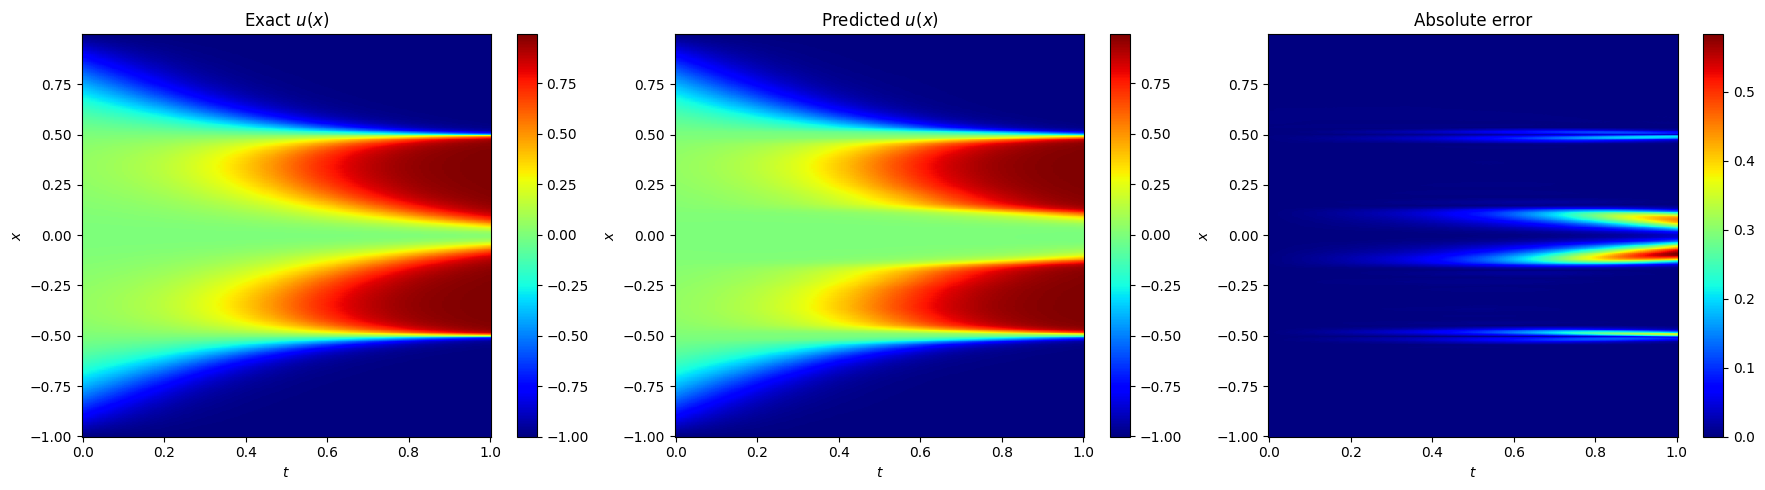

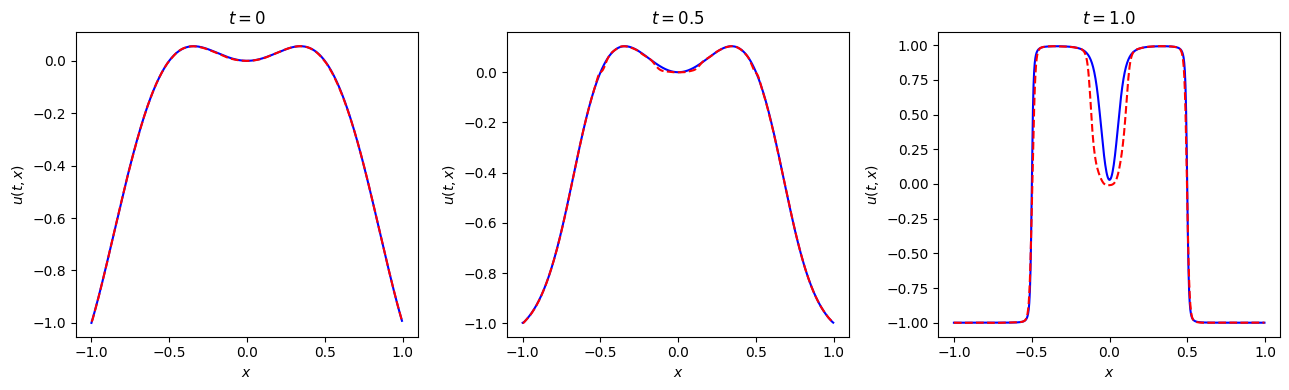

tol = 10.0


  8%|▊         | 23000/300000 [04:12<50:46, 90.94it/s, Loss=2.9653398e-05, loss_ics=2.5990892e-07, loss_res=8.941313e-06, W_min=0.9913534]    


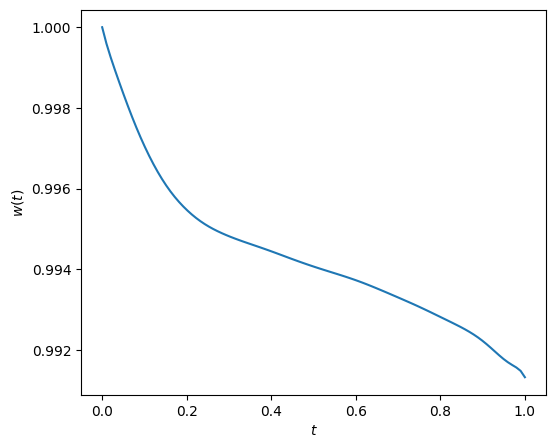

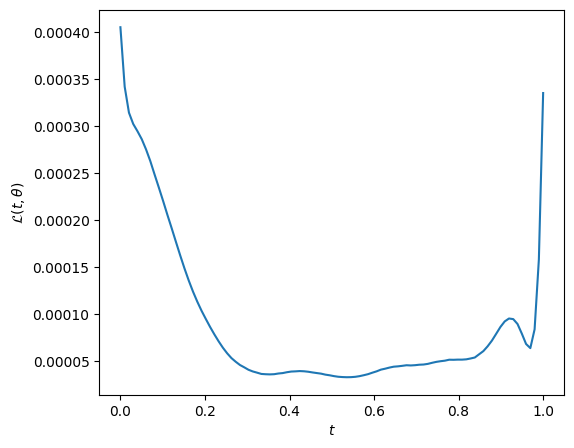

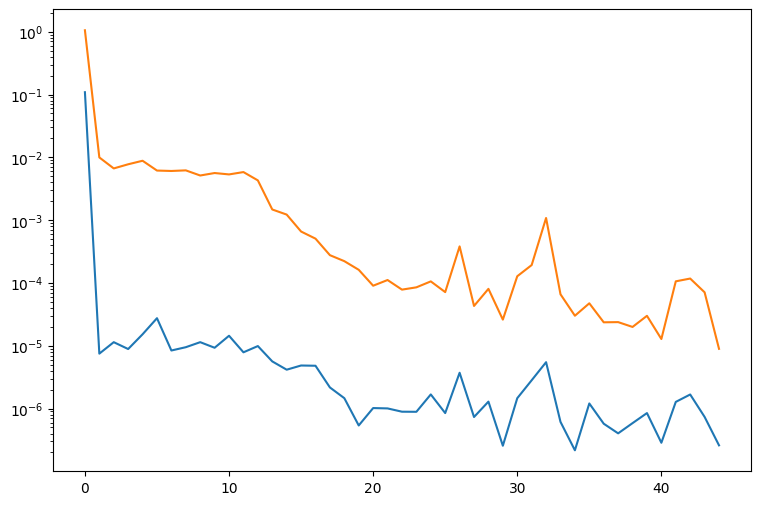

Relative l2 error: 1.022e-02


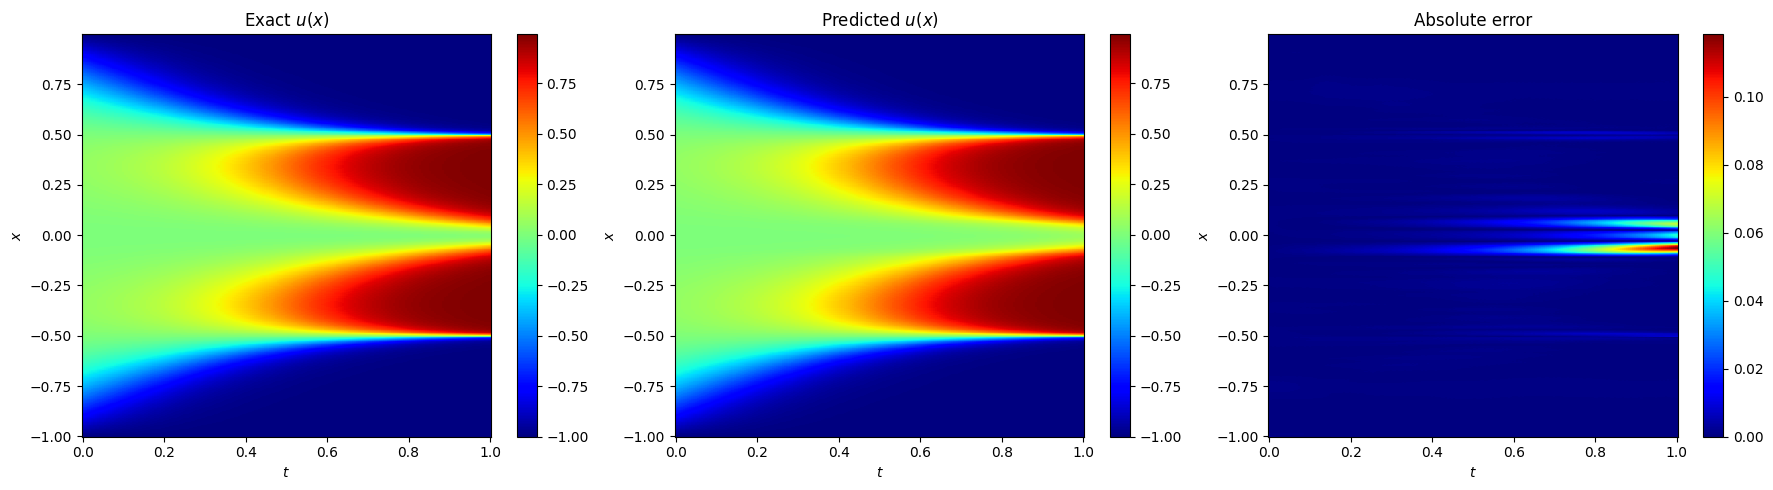

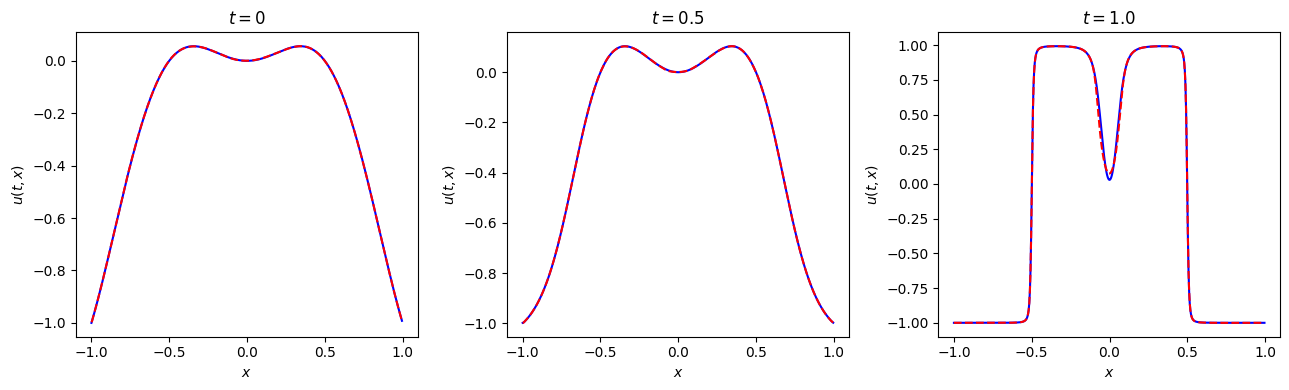

tol = 100.0


 15%|█▍        | 44308/300000 [08:07<46:52, 90.90it/s, Loss=7.604505e-06, loss_ics=7.552104e-08, loss_res=4.5950987e-06, W_min=0.95621574]    


KeyboardInterrupt: 

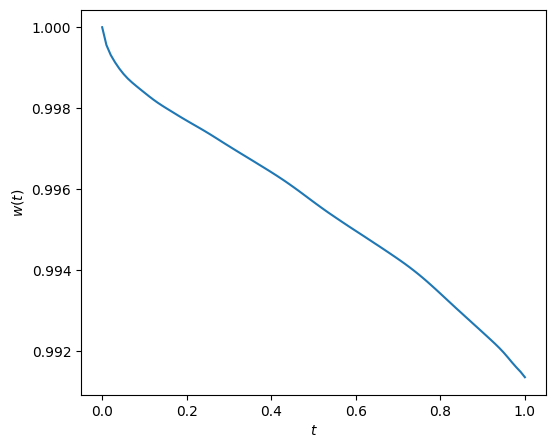

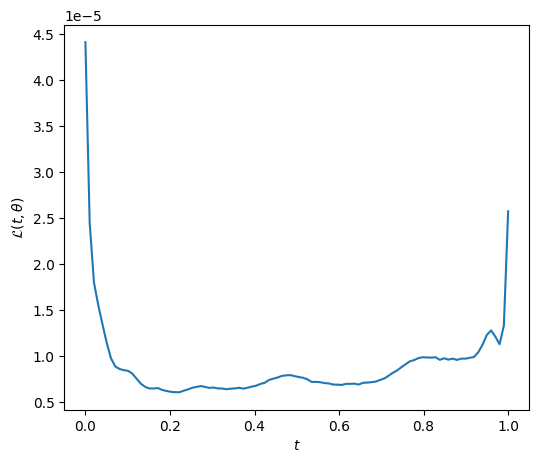

In [3]:
import os
import numpy as onp
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax import lax

import itertools
from functools import partial
from tqdm import trange

import scipy.io
from scipy.interpolate import griddata

import matplotlib.pyplot as plt


# Define MLP with exact periodicity 
def MLP(layers, L=1.0, M=1, activation=np.tanh):

    def input_encoding(t, x):
        w = 2.0 * np.pi / L
        k = np.arange(1, M + 1)
        out = np.hstack([t, 1, 
                         np.cos(k * w * x), np.sin(k * w * x)])
        return out
   
    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params

    def apply(params, inputs):
        t = inputs[0]
        x = inputs[1]
        H = input_encoding(t, x)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    
    return init, apply


# Define modified MLP
def modified_MLP(layers, L=1.0, M=1, activation=jax.nn.relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  # Define input encoding function
  def input_encoding(t, x):
      w = 2 * np.pi / L
      k = np.arange(1, M + 1)
      out = np.hstack([t, 1, 
                         np.cos(k * w * x), np.sin(k * w * x)])
      return out


  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
        
      t = inputs[0]
      x = inputs[1]
      inputs = input_encoding(t, x)  
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply     

# Define the model
class PINN:
    def __init__(self, key, layers, M, state0, t0, t1, n_t, n_x, tol):  

        # collocation points
        self.t0 = t0
        self.t1 = t1
        self.t_r = np.linspace(self.t0, self.t1, n_t)
        self.x_r = np.linspace(-1, 1, n_x)
        
        # For computing the temporal weights
        self.M = np.triu(np.ones((n_t, n_t)), k=1).T
        self.tol = tol

        # IC
        t_ic = np.zeros((x_star.shape[0], 1))
        x_ic = x_star.reshape(-1, 1)
        self.X_ic = np.hstack([t_ic, x_ic])
        self.Y_ic = state0
        
        # Initalize the network
        # self.init, self.apply = MLP(layers, L=2.0, M=M, activation=np.tanh)
        self.init, self.apply = modified_MLP(layers, L=2.0, M=M, activation=np.tanh)
        params = self.init(rng_key = key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params) 

        # Evaluate the network and the residual over the grid
        self.u_pred_fn = vmap(vmap(self.neural_net, (None, 0, None)), (None, None, 0))  # consistent with the dataset
        self.r_pred_fn = vmap(vmap(self.residual_net, (None, None, 0)), (None, 0, None))

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []
    
    def neural_net(self, params, t, x):
        z = np.stack([t, x])
        outputs = self.apply(params, z)
        return outputs[0]

    def residual_net(self, params, t, x): 
        u = self.neural_net(params, t, x)
        u_t = grad(self.neural_net, argnums=1)(params, t, x)
        u_x = grad(self.neural_net, argnums=2)(params, t, x)
        u_xx = grad(grad(self.neural_net, argnums = 2), argnums=2)(params, t, x)
        return u_t + 5 * u**3 - 5 * u - nu * u_xx   

    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        L_t = np.mean(r_pred**2, axis=1)
        W = lax.stop_gradient(np.exp(- tol * (self.M @ L_t)))
        return L_t, W

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params):
        # Evaluate the network over IC
        u_pred = vmap(self.neural_net, (None, 0, 0))(params, self.X_ic[:,0], self.X_ic[:,1])
        # Compute the initial loss
        loss_ics = np.mean((self.Y_ic.flatten() - u_pred.flatten())**2)
        return loss_ics

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params): 
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        # Compute loss
        loss_r = np.mean(r_pred**2)
        return loss_r  

    @partial(jit, static_argnums=(0,))  
    def loss(self, params):
        L0 = 100 * self.loss_ics(params)
        L_t, W = self.residuals_and_weights(params, self.tol)
        # Compute loss
        loss = np.mean(W * L_t) + L0
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params)

        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, nIter = 10000):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_ics_value = self.loss_ics(params)
                loss_res_value = self.loss_res(params)
                L_t_value, W_value = self.residuals_and_weights(params, self.tol)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)
                self.W_log.append(W_value)
                self.L_t_log.append(L_t_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value, 
                                  'loss_res':  loss_res_value,
                                  'W_min'  : W_value.min()})
                if W_value.min() > 0.99:
                    break
           
# load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

 # Create PINNs model
key = random.PRNGKey(1234)

# Network architecture
M = 10
d0 = M * 2 + 2
layers = [d0, 256, 256, 256, 1]

# hpyer-parameters
nu = 0.0001
t0 = 0.0
t1 = 1.0
n_t = 100
n_x = 256
tols = [float(f"10e{i}") for i in range(-2, 2)]

state0 = usol[:, 0:1]

model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, tols[0])

for tol in tols:
    model.tol = tol
    print(f"tol = {model.tol}")
    # Train
    model.train(nIter=300000)
    fig = plt.figure(figsize=(9, 6))
    plt.plot(model.loss_ics_log, label='IC Loss')
    plt.plot(model.loss_res_log, label='Residual Loss')
    plt.yscale('log')
    plt.show()

    # Get trained network parameters
    params = model.get_params(model.opt_state)
    u_pred = model.u_pred_fn(params, t_star, x_star)
    error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol) 
    print('Relative l2 error: {:.3e}'.format(error))

    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(TT, XX, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Exact $u(x)$')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(TT, XX, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Predicted $u(x)$')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(13, 4))
    plt.subplot(1, 3, 1)
    plt.plot(x_star, usol[:,0], color='blue')
    plt.plot(x_star, u_pred[:,0], '--', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(t, x)$')
    plt.title('$t = 0$')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.plot(x_star, usol[:,25], color='blue')
    plt.plot(x_star, u_pred[:,25], '--', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(t, x)$')
    plt.title('$t = 0.5$')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.plot(x_star, usol[:,-1], color='blue')
    plt.plot(x_star, u_pred[:,-1], '--', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(t, x)$')
    plt.title('$t = 1.0$')
    plt.tight_layout()
    plt.show()

    L_t, W = model.residuals_and_weights(params, model.tol)
    fig = plt.figure(figsize=(6, 5))
    plt.plot(model.t_r, W)
    plt.xlabel('$t$')
    plt.ylabel('$w(t)$')

    fig = plt.figure(figsize=(6, 5))
    plt.plot(model.t_r, L_t)
    plt.xlabel('$t$')
    plt.ylabel('$\mathcal{L}(t, \\theta)$')

# Skip Connections

tol = 0.1


  4%|▎         | 11000/300000 [02:15<59:22, 81.13it/s, Loss=0.0007467013, loss_ics=4.273562e-07, loss_res=0.00071764033, W_min=0.99295825]


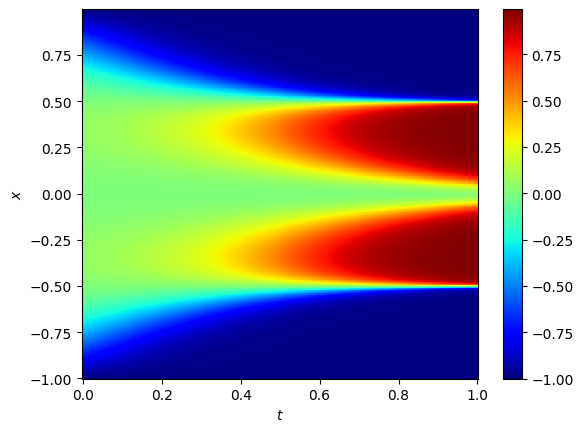

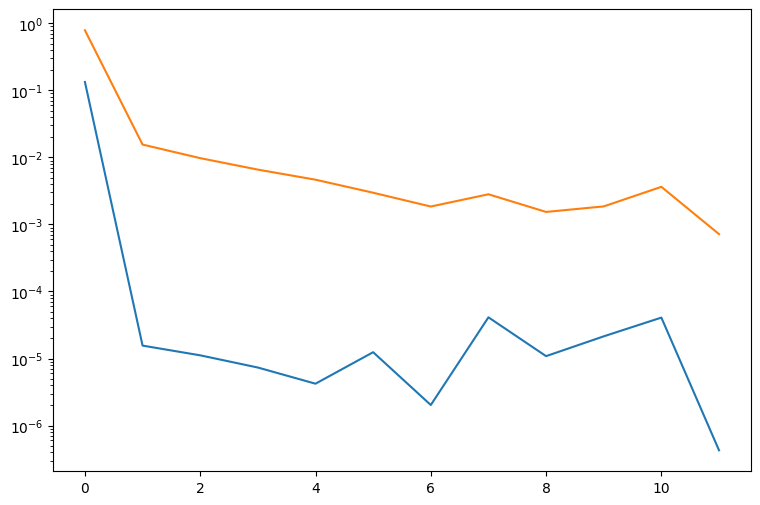

Relative l2 error: 5.542e-01


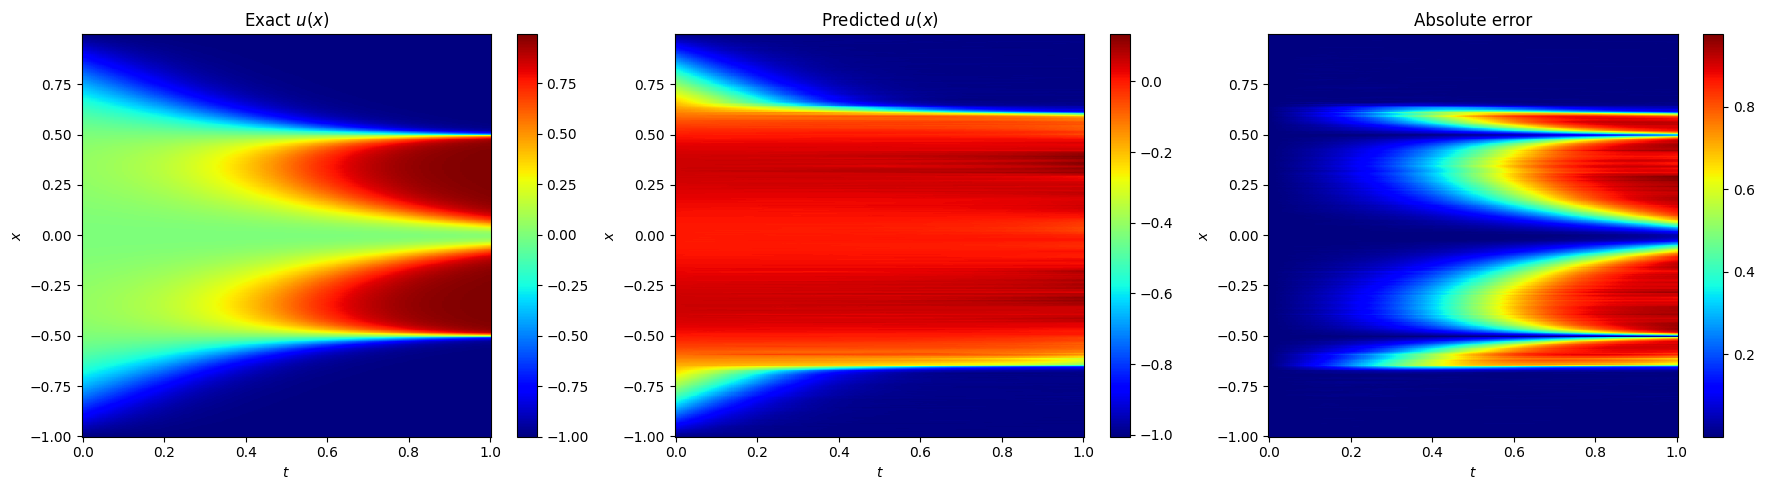

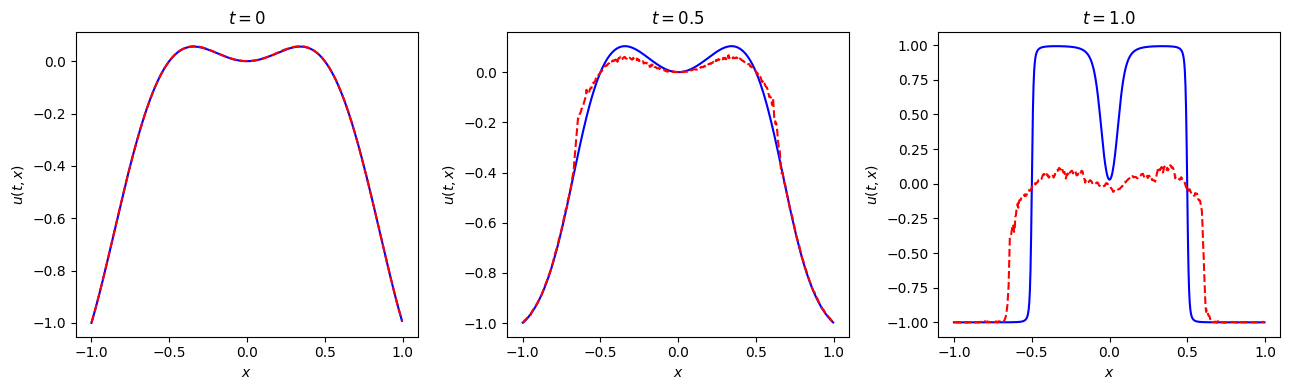

tol = 1.0


  3%|▎         | 9634/300000 [01:41<50:52, 95.12it/s, Loss=0.0010991337, loss_ics=4.535852e-06, loss_res=0.00064936397, W_min=0.938454]      


KeyboardInterrupt: 

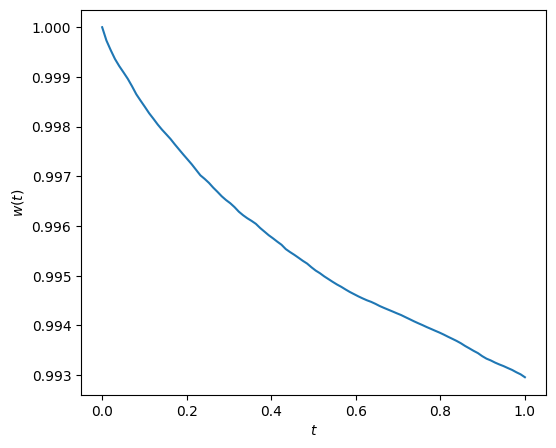

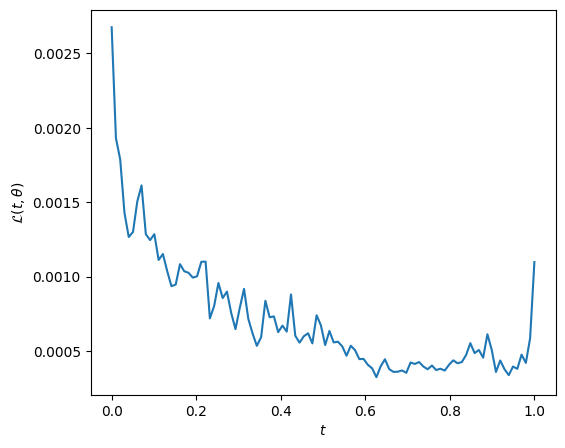

In [2]:
import os
import numpy as onp
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax import lax

import itertools
from functools import partial
from tqdm import trange

import scipy.io
from scipy.interpolate import griddata

import matplotlib.pyplot as plt


# Define MLP with exact periodicity 
def MLP(layers, L=1.0, M=1, activation=np.tanh):

    def input_encoding(t, x):
        w = 2.0 * np.pi / L
        k = np.arange(1, M + 1)
        out = np.hstack([t, 1, 
                         np.cos(k * w * x), np.sin(k * w * x)])
        return out
   
    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params

    def apply(params, inputs):
        t = inputs[0]
        x = inputs[1]
        H = input_encoding(t, x)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    
    return init, apply


# Define modified MLP
def modified_MLP(layers, L=1.0, M=1, activation=jax.nn.relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  # Define input encoding function
  def input_encoding(t, x):
      w = 2 * np.pi / L
      k = np.arange(1, M + 1)
      out = np.hstack([t, 1, 
                         np.cos(k * w * x), np.sin(k * w * x)])
      return out


  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
        
      t = inputs[0]
      x = inputs[1]
      inputs = input_encoding(t, x)  
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply  

def modified_MLP_skip_connections(layers, L=1.0, M=1, activation=jax.nn.relu):
    """
    A modified MLP with additive skip connections and gating vectors U, V.
    
    Arguments:
        layers: list of layer sizes, e.g. [input_dim, hidden1, hidden2, ..., output_dim]
        L: float, domain size for the encoding
        M: integer, number of sin/cos modes in the encoding
        activation: activation function, e.g. jax.nn.relu
    
    Returns:
        init: a function that initializes network parameters
        apply: a function that applies the network to an input (t, x)
    """
    # Xavier (Glorot) initializer
    def xavier_init(key, d_in, d_out):
        glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
        W = glorot_stddev * random.normal(key, (d_in, d_out))
        b = np.zeros(d_out)
        return W, b

    # Input encoding: [ t, 1, cos(k*2π/L*x), sin(k*2π/L*x) ], k=1..M
    def input_encoding(t, x):
        w = 2 * np.pi / L
        k = np.arange(1, M + 1)
        # shape: (1 + 1 + 2*M) = (2M+2,)
        out = np.hstack([
            t,
            1.0,
            np.cos(k * w * x),
            np.sin(k * w * x)
        ])
        return out

    def init(rng_key):
        """
        Initializes all parameters:
          - Two special weight/bias pairs (U1, b1) and (U2, b2) for gating
          - The MLP layers
        """
        # For reproducibility, you might also want to split keys differently
        U1, b1 = xavier_init(random.PRNGKey(12345), layers[0], layers[1])
        U2, b2 = xavier_init(random.PRNGKey(54321), layers[0], layers[1])

        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            W, b = xavier_init(k1, d_in, d_out)
            return W, b

        key, *keys = random.split(rng_key, len(layers))
        params_mlp = list(map(init_layer, keys, layers[:-1], layers[1:]))

        return (params_mlp, U1, b1, U2, b2)

    def apply(params, inputs):
        """
        Forward pass:
          1. Encode inputs.
          2. Compute gating vectors U, V.
          3. For each hidden layer, compute residual = activation(...) * U + (1 - ...) * V,
             then add this residual to the layer input (skip connection).
          4. Final layer is linear.
        """
        params_mlp, U1, b1, U2, b2 = params

        # Extract t, x from inputs
        t, x = inputs[0], inputs[1]

        # Step 1: Input encoding
        x_enc = input_encoding(t, x)  # shape = layers[0]

        # Step 2: Compute gating vectors U, V
        # Both are based on the encoded input x_enc
        U = activation(np.dot(x_enc, U1) + b1)
        V = activation(np.dot(x_enc, U2) + b2)

        # We'll feed x_enc through our hidden layers
        h = x_enc

        # Hidden layers with skip connections
        for W, b in params_mlp[:-1]:
            # compute activation
            out = activation(np.dot(h, W) + b)
            # apply gating
            gated_out = out * U + (1.0 - out) * V
            # skip/add
            h = h + gated_out

        # Final layer (linear)
        W_out, b_out = params_mlp[-1]
        outputs = np.dot(h, W_out) + b_out
        return outputs

    return init, apply   

# Define the model
class PINN:
    def __init__(self, key, layers, M, state0, t0, t1, n_t, n_x, tol):  

        # collocation points
        self.t0 = t0
        self.t1 = t1
        self.t_r = np.linspace(self.t0, self.t1, n_t)
        self.x_r = np.linspace(-1, 1, n_x)
        
        # For computing the temporal weights
        self.M = np.triu(np.ones((n_t, n_t)), k=1).T
        self.tol = tol

        # IC
        t_ic = np.zeros((x_star.shape[0], 1))
        x_ic = x_star.reshape(-1, 1)
        self.X_ic = np.hstack([t_ic, x_ic])
        self.Y_ic = state0
        
        # Initalize the network
        # self.init, self.apply = MLP(layers, L=2.0, M=M, activation=np.tanh)
        # self.init, self.apply = modified_MLP(layers, L=2.0, M=M, activation=np.tanh)
        self.init, self.apply = modified_MLP(layers, L=2.0, M=M, activation=jax.nn.relu6)
        # self.init, self.apply = modified_MLP_skip_connections(layers, L=2.0, M=M, activation=np.tanh) 

        params = self.init(rng_key = key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params) 

        # Evaluate the network and the residual over the grid
        self.u_pred_fn = vmap(vmap(self.neural_net, (None, 0, None)), (None, None, 0))  # consistent with the dataset
        self.r_pred_fn = vmap(vmap(self.residual_net, (None, None, 0)), (None, 0, None))

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []
    
    def neural_net(self, params, t, x):
        z = np.stack([t, x])
        outputs = self.apply(params, z)
        return outputs[0]

    def residual_net(self, params, t, x): 
        u = self.neural_net(params, t, x)
        u_t = grad(self.neural_net, argnums=1)(params, t, x)
        u_x = grad(self.neural_net, argnums=2)(params, t, x)
        u_xx = grad(grad(self.neural_net, argnums = 2), argnums=2)(params, t, x)
        return u_t + 5 * u**3 - 5 * u - nu * u_xx   

    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        L_t = np.mean(r_pred**2, axis=1)
        W = lax.stop_gradient(np.exp(- tol * (self.M @ L_t)))
        return L_t, W

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params):
        # Evaluate the network over IC
        u_pred = vmap(self.neural_net, (None, 0, 0))(params, self.X_ic[:,0], self.X_ic[:,1])
        # Compute the initial loss
        loss_ics = np.mean((self.Y_ic.flatten() - u_pred.flatten())**2)
        return loss_ics

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params): 
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        # Compute loss
        loss_r = np.mean(r_pred**2)
        return loss_r  

    @partial(jit, static_argnums=(0,))  
    def loss(self, params):
        L0 = 100 * self.loss_ics(params)
        L_t, W = self.residuals_and_weights(params, self.tol)
        # Compute loss
        loss = np.mean(W * L_t) + L0
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params)

        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, nIter = 10000):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_ics_value = self.loss_ics(params)
                loss_res_value = self.loss_res(params)
                L_t_value, W_value = self.residuals_and_weights(params, self.tol)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)
                self.W_log.append(W_value)
                self.L_t_log.append(L_t_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value, 
                                  'loss_res':  loss_res_value,
                                  'W_min'  : W_value.min()})
                if W_value.min() > 0.99:
                    break
           
# load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

 # Create PINNs model
key = random.PRNGKey(1234)

# Network architecture
M = 10
d0 = M * 2 + 2
layers = [d0, 256, 256, 256, 1]

# hpyer-parameters
nu = 0.0001
t0 = 0.0
t1 = 1.0
n_t = 100
n_x = 256
tols = [float(f"10e{i}") for i in range(-2, 2)]

state0 = usol[:, 0:1]

model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, tols[0])

for tol in tols:
    model.tol = tol
    print(f"tol = {model.tol}")
    # Train
    model.train(nIter=300000)
    fig = plt.figure(figsize=(9, 6))
    plt.plot(model.loss_ics_log, label='IC Loss')
    plt.plot(model.loss_res_log, label='Residual Loss')
    plt.yscale('log')
    plt.show()

    # Get trained network parameters
    params = model.get_params(model.opt_state)
    u_pred = model.u_pred_fn(params, t_star, x_star)
    error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol) 
    print('Relative l2 error: {:.3e}'.format(error))

    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(TT, XX, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Exact $u(x)$')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(TT, XX, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Predicted $u(x)$')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(13, 4))
    plt.subplot(1, 3, 1)
    plt.plot(x_star, usol[:,0], color='blue')
    plt.plot(x_star, u_pred[:,0], '--', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(t, x)$')
    plt.title('$t = 0$')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.plot(x_star, usol[:,25], color='blue')
    plt.plot(x_star, u_pred[:,25], '--', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(t, x)$')
    plt.title('$t = 0.5$')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.plot(x_star, usol[:,-1], color='blue')
    plt.plot(x_star, u_pred[:,-1], '--', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(t, x)$')
    plt.title('$t = 1.0$')
    plt.tight_layout()
    plt.show()

    L_t, W = model.residuals_and_weights(params, model.tol)
    fig = plt.figure(figsize=(6, 5))
    plt.plot(model.t_r, W)
    plt.xlabel('$t$')
    plt.ylabel('$w(t)$')

    fig = plt.figure(figsize=(6, 5))
    plt.plot(model.t_r, L_t)
    plt.xlabel('$t$')
    plt.ylabel('$\mathcal{L}(t, \\theta)$')

[0.1, 1.0, 10.0, 100.0]

0.1

# Functional Causality Parameter

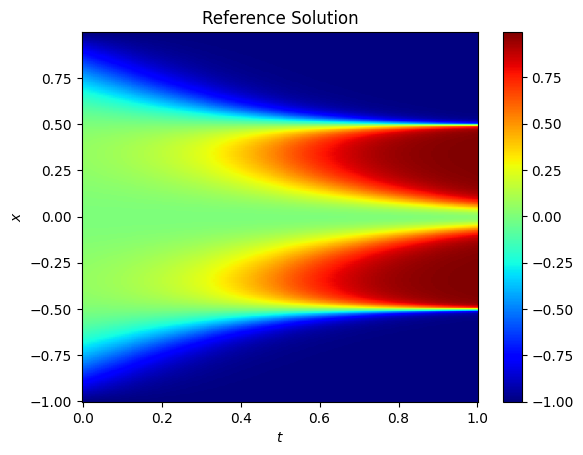

In [1]:
import numpy as onp
import jax.numpy as np
import jax
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax import lax

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

import scipy.io
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

# Define MLP with exact periodicity
def MLP(layers, L=1.0, M=1, activation=np.tanh):

    def input_encoding(t, x):
        w = 2.0 * np.pi / L
        k = np.arange(1, M + 1)
        out = np.hstack([t, 1,
                         np.cos(k * w * x), np.sin(k * w * x)])
        return out

    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        t = inputs[0]
        x = inputs[1]
        H = input_encoding(t, x)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs

    return init, apply

# Define modified MLP
def modified_MLP(layers, L=1.0, M=1, activation=jax.nn.relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  # Define input encoding function
  def input_encoding(t, x):
      w = 2 * np.pi / L
      k = np.arange(1, M + 1)
      out = np.hstack([t, 1, 
                         np.cos(k * w * x), np.sin(k * w * x)])
      return out


  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
        
      t = inputs[0]
      x = inputs[1]
      inputs = input_encoding(t, x)  
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply     


# Define the model
class PINN:
    def __init__(self, key, layers, M, state0, t0, t1, n_t, n_x, epsilon_func, epsilon_params):

        # collocation points
        self.t0 = t0
        self.t1 = t1
        self.t_r = np.linspace(self.t0, self.t1, n_t)
        self.x_r = np.linspace(-1, 1, n_x)

        # For computing the cumulative sum over time
        self.M_mat = np.triu(np.ones((n_t, n_t)), k=0).T

        # Store the epsilon function and parameters
        self.epsilon_func = epsilon_func
        self.epsilon_params = epsilon_params

        # IC
        t_ic = np.zeros((x_star.shape[0], 1))
        x_ic = x_star.reshape(-1, 1)
        self.X_ic = np.hstack([t_ic, x_ic])
        self.Y_ic = state0

        # Initialize the network
        self.init, self.apply = MLP(layers, L=2.0, M=M, activation=np.tanh)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Evaluate the network and the residual over the grid
        self.u_pred_fn = vmap(vmap(self.neural_net, (None, 0, None)), (None, None, 0))  # consistent with the dataset
        self.r_pred_fn = vmap(vmap(self.residual_net, (None, None, 0)), (None, 0, None))

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []

    def neural_net(self, params, t, x):
        z = np.stack([t, x])
        outputs = self.apply(params, z)
        return outputs[0]

    def residual_net(self, params, t, x):
        u = self.neural_net(params, t, x)
        u_t = grad(self.neural_net, argnums=1)(params, t, x)
        u_xx = grad(grad(self.neural_net, argnums=2), argnums=2)(params, t, x)
        return u_t + 5 * u ** 3 - 5 * u - nu * u_xx

    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params):
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        L_t = np.mean(r_pred ** 2, axis=1)

        # Compute cumulative loss over time
        cumulative_L_t = self.M_mat @ L_t

        # Compute epsilon based on the chosen functional form
        if self.epsilon_func == epsilon_gradient_based:
            epsilon = self.epsilon_func(self.t_r, cumulative_L_t, params, self, self.x_r, *self.epsilon_params)
        else:
            epsilon = self.epsilon_func(self.t_r, cumulative_L_t, *self.epsilon_params)

        # Compute weights
        W = lax.stop_gradient(np.exp(-epsilon * cumulative_L_t))

        return L_t, W


    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params):
        # Evaluate the network over IC
        u_pred = vmap(self.neural_net, (None, 0, 0))(params, self.X_ic[:, 0], self.X_ic[:, 1])
        # Compute the initial loss
        loss_ics = np.mean((self.Y_ic.flatten() - u_pred.flatten()) ** 2)
        return loss_ics

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params):
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        # Compute loss
        loss_r = np.mean(r_pred ** 2)
        return loss_r

    @partial(jit, static_argnums=(0,))
    def loss(self, params):
        L0 = 100 * self.loss_ics(params)
        L_t, W = self.residuals_and_weights(params)
        # Compute loss
        loss = np.mean(W * L_t) + L0
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, nIter=10000):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state)

            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_ics_value = self.loss_ics(params)
                loss_res_value = self.loss_res(params)
                L_t_value, W_value = self.residuals_and_weights(params)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)
                self.W_log.append(W_value)
                self.L_t_log.append(L_t_value)

                pbar.set_postfix({'Loss': loss_value,
                                  'loss_ics': loss_ics_value,
                                  'loss_res': loss_res_value})

    # Additional methods for evaluation can be added here

# Define epsilon functions
def epsilon_constant(t, cumulative_L_t, epsilon_value):
    return epsilon_value

def epsilon_time_dependent(t, cumulative_L_t, epsilon_0, decay_rate):
    return epsilon_0 * np.exp(-decay_rate * t)

def epsilon_residual_based(t, cumulative_L_t, alpha_param, lambda_param):
    return alpha_param / (1 + lambda_param * cumulative_L_t)

def epsilon_gradient_based(t, cumulative_L_t, params, model, x_r, alpha_param, beta_param):
    # t: shape [n_t]
    # x_r: shape [n_x]
    # Compute u_x at all combinations of t and x_r
    # Define a function that computes u_x at scalar t_i and x_j
    def u_x_single(t_i, x_j):
        return grad(model.neural_net, argnums=2)(params, t_i, x_j)
    
    # Vectorize over x_r first, then over t
    u_x_fn = vmap(lambda t_i: vmap(lambda x_j: u_x_single(t_i, x_j))(x_r))(t)
    # u_x_fn has shape [n_t, n_x]
    
    u_x = u_x_fn  # u_x is of shape [n_t, n_x]
    
    # Compute mean absolute value over x (axis=1)
    u_x_abs_mean = np.mean(np.abs(u_x), axis=1)  # Shape [n_t]
    return alpha_param * u_x_abs_mean + beta_param


# Load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.figure()
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Reference Solution')
plt.show()

# Create PINNs model
key = random.PRNGKey(1234)

# Network architecture
M = 10
d0 = M * 2 + 2
layers = [d0, 36, 36, 36, 36, 1]

# Hyper-parameters
nu = 0.0001
t0 = 0.0
t1 = 1.0
n_t = 100
n_x = 128
n_iter = 300000

state0 = usol[:, 0:1]

## Constant 𝜖
Baseline from Wang

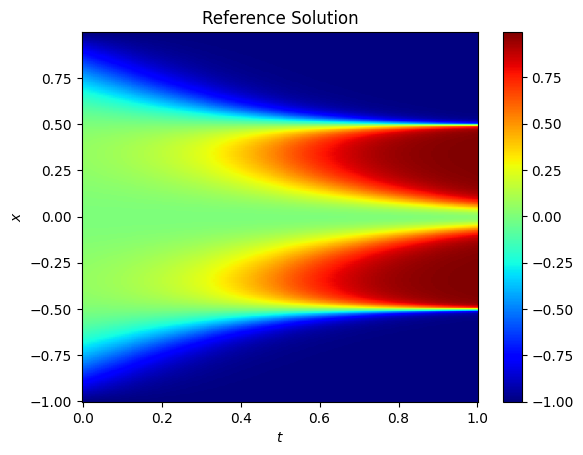

Training with annealing causality parameter (epsilon)...


100%|██████████| 1500000/1500000 [35:31<00:00, 703.78it/s, Loss=0.00044286437, loss_ics=5.6900916e-07, loss_res=0.00040340627]


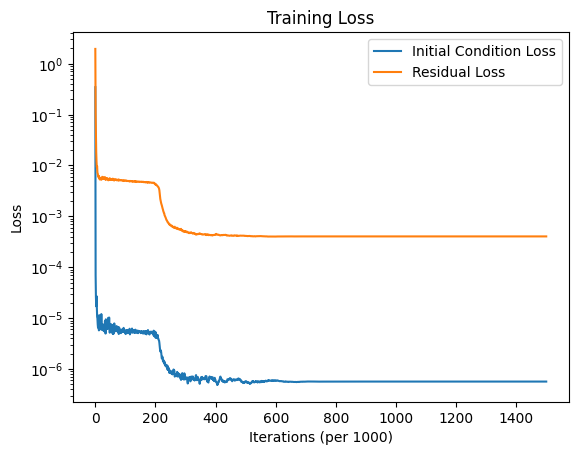

Relative L2 error: 2.420e-01


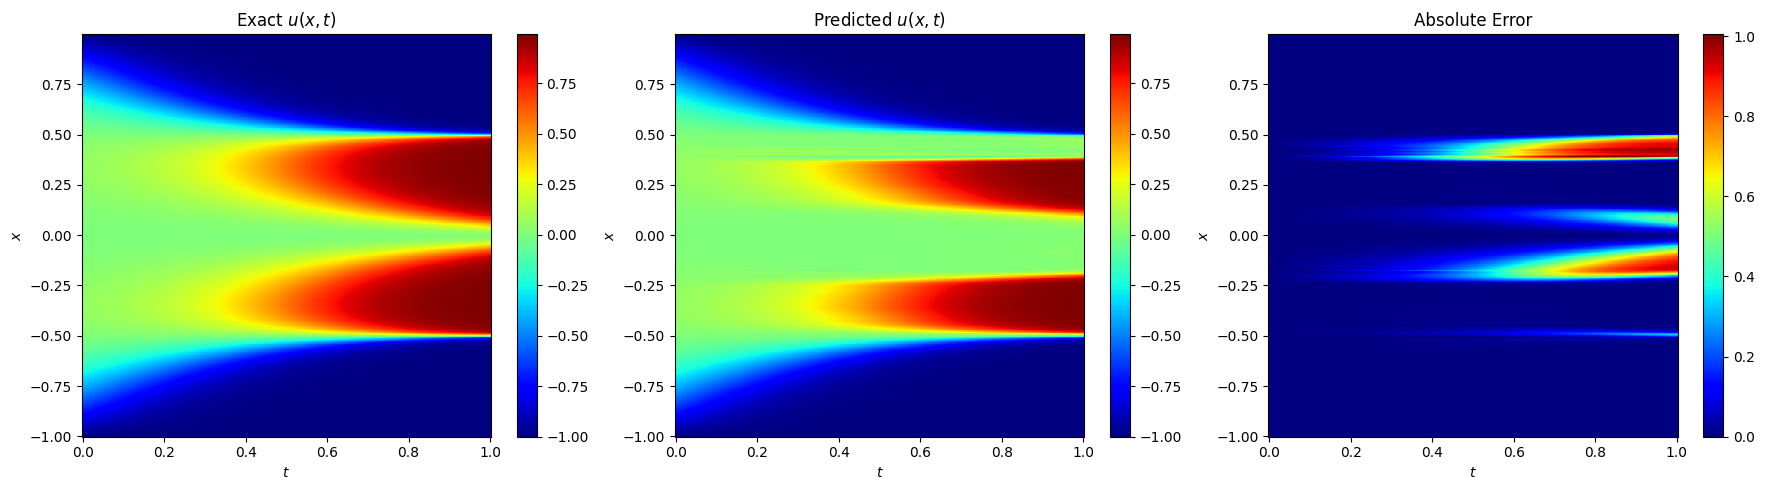

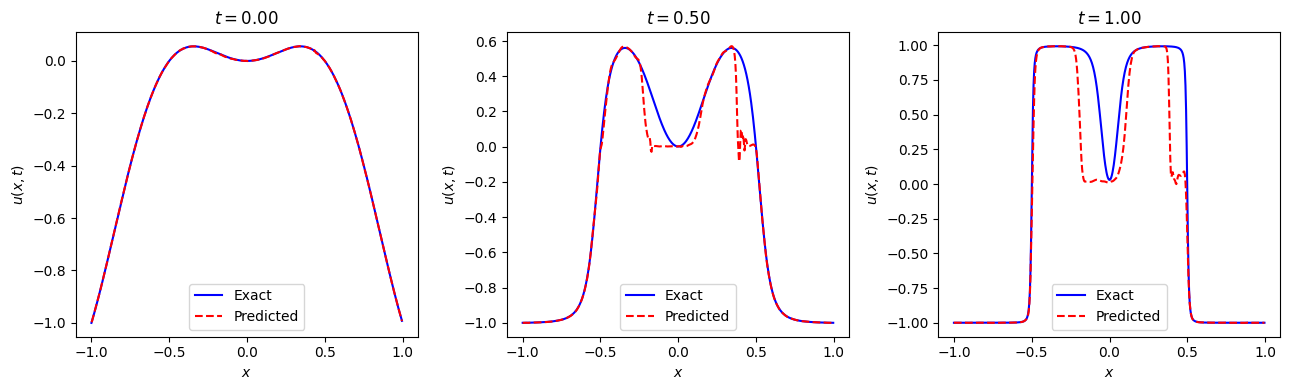

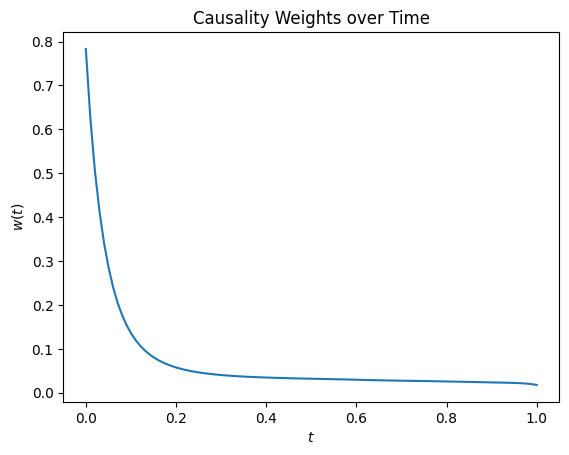

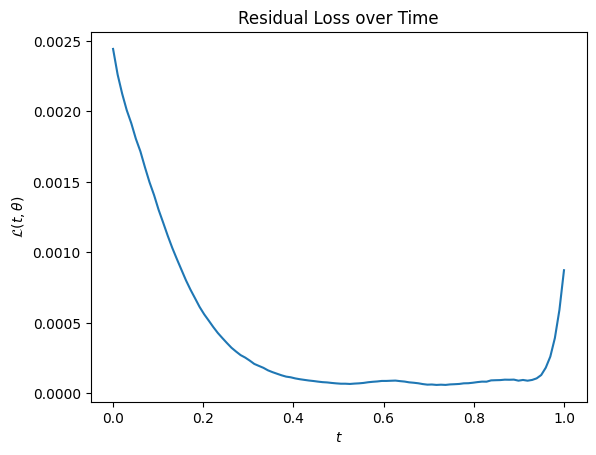

In [7]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax import lax

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

import scipy.io
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

# Define MLP with exact periodicity
def MLP(layers, L=1.0, M=1, activation=np.tanh):

    def input_encoding(t, x):
        w = 2.0 * np.pi / L
        k = np.arange(1, M + 1)
        out = np.hstack([t, 1,
                         np.cos(k * w * x), np.sin(k * w * x)])
        return out

    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        t = inputs[0]
        x = inputs[1]
        H = input_encoding(t, x)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs

    return init, apply

# Define the model
class PINN:
    def __init__(self, key, layers, M, state0, t0, t1, n_t, n_x, tol):

        # collocation points
        self.t0 = t0
        self.t1 = t1
        self.t_r = np.linspace(self.t0, self.t1, n_t)
        self.x_r = np.linspace(-1, 1, n_x)

        # For computing the cumulative sum over time
        self.M_mat = np.triu(np.ones((n_t, n_t)), k=0).T

        # Initial causality parameter (epsilon)
        self.tol = tol

        # IC
        t_ic = np.zeros((x_star.shape[0], 1))
        x_ic = x_star.reshape(-1, 1)
        self.X_ic = np.hstack([t_ic, x_ic])
        self.Y_ic = state0

        # Initialize the network
        self.init, self.apply = MLP(layers, L=2.0, M=M, activation=np.tanh)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Evaluate the network and the residual over the grid
        self.u_pred_fn = vmap(vmap(self.neural_net, (None, 0, None)), (None, None, 0))  # consistent with the dataset
        self.r_pred_fn = vmap(vmap(self.residual_net, (None, None, 0)), (None, 0, None))

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []

    def neural_net(self, params, t, x):
        z = np.stack([t, x])
        outputs = self.apply(params, z)
        return outputs[0]

    def residual_net(self, params, t, x):
        u = self.neural_net(params, t, x)
        u_t = grad(self.neural_net, argnums=1)(params, t, x)
        u_xx = grad(grad(self.neural_net, argnums=2), argnums=2)(params, t, x)
        return u_t + 5 * u ** 3 - 5 * u - nu * u_xx

    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        L_t = np.mean(r_pred ** 2, axis=1)
        cumulative_L_t = self.M_mat @ L_t
        W = lax.stop_gradient(np.exp(-tol * cumulative_L_t))
        return L_t, W

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params):
        # Evaluate the network over IC
        u_pred = vmap(self.neural_net, (None, 0, 0))(params, self.X_ic[:, 0], self.X_ic[:, 1])
        # Compute the initial loss
        loss_ics = np.mean((self.Y_ic.flatten() - u_pred.flatten()) ** 2)
        return loss_ics

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params):
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        # Compute loss
        loss_r = np.mean(r_pred ** 2)
        return loss_r

    @partial(jit, static_argnums=(0,))
    def loss(self, params):
        L0 = 100 * self.loss_ics(params)
        L_t, W = self.residuals_and_weights(params, self.tol)
        # Compute loss
        loss = np.mean(W * L_t) + L0
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop with annealing tol
    def train(self, tol_sequence, nIter_per_tol):
        total_iterations = len(tol_sequence) * nIter_per_tol
        pbar = trange(total_iterations)
        iteration = 0
        # Main training loop
        for tol in tol_sequence:
            self.tol = tol  # Update the model's tol value
            for it in range(nIter_per_tol):
                self.current_count = next(self.itercount)
                self.opt_state = self.step(self.current_count, self.opt_state)

                if iteration % 1000 == 0:
                    params = self.get_params(self.opt_state)

                    loss_value = self.loss(params)
                    loss_ics_value = self.loss_ics(params)
                    loss_res_value = self.loss_res(params)
                    L_t_value, W_value = self.residuals_and_weights(params, self.tol)

                    self.loss_log.append(loss_value)
                    self.loss_ics_log.append(loss_ics_value)
                    self.loss_res_log.append(loss_res_value)
                    self.W_log.append(W_value)
                    self.L_t_log.append(L_t_value)

                    pbar.set_postfix({'Loss': loss_value,
                                      'loss_ics': loss_ics_value,
                                      'loss_res': loss_res_value})

                pbar.update(1)
                iteration += 1

    # Additional methods for evaluation can be added here

# Load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.figure()
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Reference Solution')
plt.show()

# Create PINNs model
key = random.PRNGKey(1234)

# Network architecture
M = 10
d0 = M * 2 + 2
layers = [d0, 36, 36, 36, 36, 1]

# Hyper-parameters
nu = 0.0001
t0 = 0.0
t1 = 1.0
n_t = 100
n_x = 128

state0 = usol[:, 0:1]

# Define the tol sequence and number of iterations per tol
tol_sequence = [1e-2, 1e-1, 1e0, 1e1, 1e2]
nIter_per_tol = 300000  # Number of iterations per tol value

# Initialize the model with the first tol value
model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, tol_sequence[0])

# Train the model with annealing tol
print("Training with annealing causality parameter (epsilon)...")
model.train(tol_sequence, nIter_per_tol)

# Plot loss curves
plt.figure()
plt.plot(model.loss_ics_log, label='Initial Condition Loss')
plt.plot(model.loss_res_log, label='Residual Loss')
plt.yscale('log')
plt.xlabel('Iterations (per 1000)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Get trained network parameters
params = model.get_params(model.opt_state)
u_pred = model.u_pred_fn(params, t_star, x_star)
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol)
print('Relative L2 error: {:.3e}'.format(error))

# Plot results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute Error')
plt.tight_layout()
plt.show()

# Plot snapshots at different time points
fig = plt.figure(figsize=(13, 4))
time_indices = [0, len(t_star)//2, -1]
time_labels = [t_star[0], t_star[len(t_star)//2], t_star[-1]]
for i, idx in enumerate(time_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(x_star, usol[:, idx], label='Exact', color='blue')
    plt.plot(x_star, u_pred[:, idx], '--', label='Predicted', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(x, t)$')
    plt.title(f'$t = {time_labels[i]:.2f}$')
    plt.legend()
    plt.tight_layout()
plt.show()

# Plot weights and cumulative loss over time
L_t, W = model.residuals_and_weights(params, model.tol)
plt.figure()
plt.plot(model.t_r, W)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')
plt.title('Causality Weights over Time')
plt.show()

plt.figure()
plt.plot(model.t_r, L_t)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')
plt.title('Residual Loss over Time')
plt.show()


100%|██████████| 300000/300000 [07:09<00:00, 698.69it/s, Loss=8.282909e-05, loss_ics=2.9899243e-07, loss_res=7.8383e-05]      


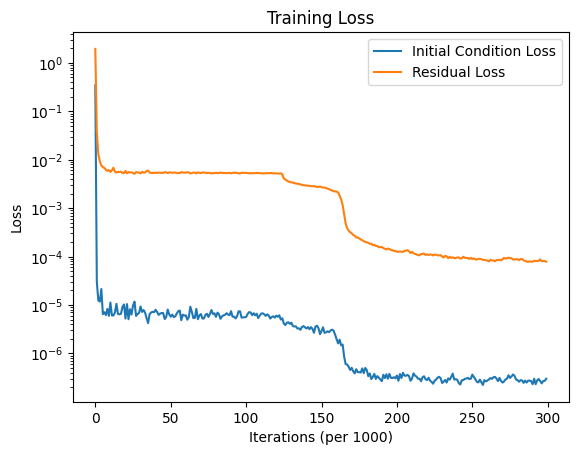

Relative L2 error: 8.392e-02


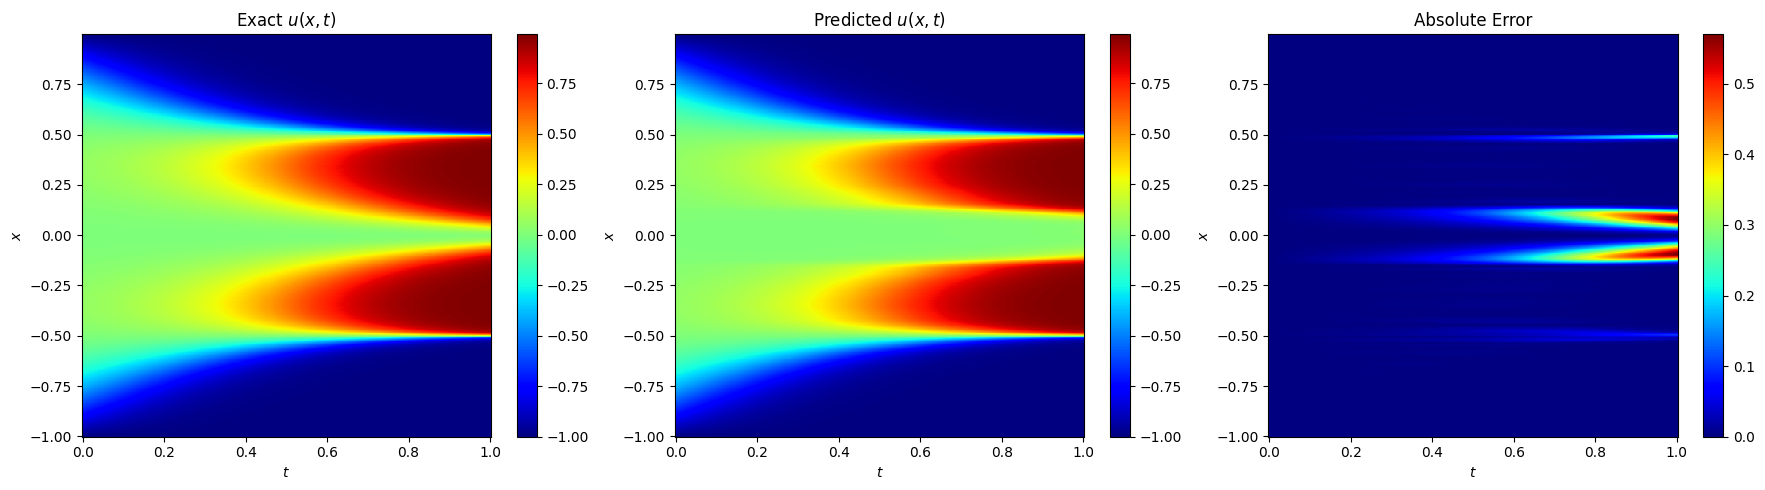

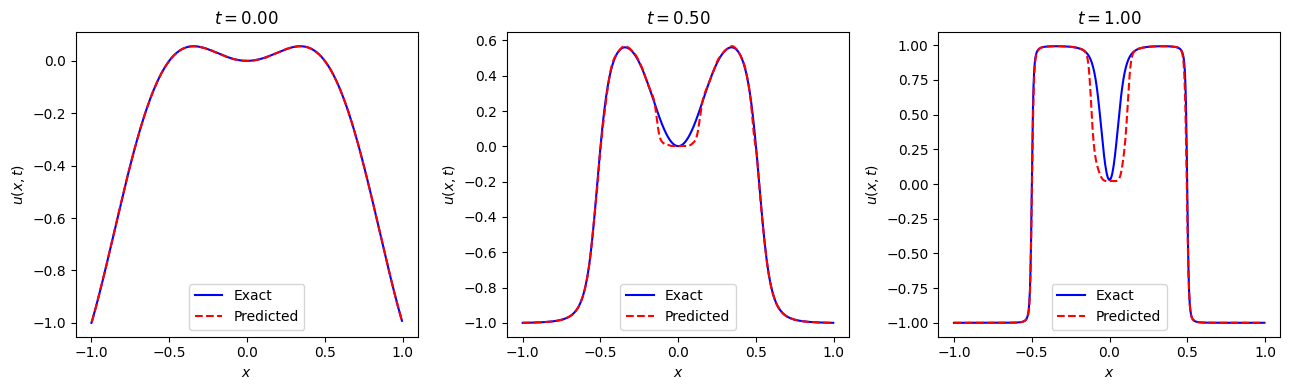

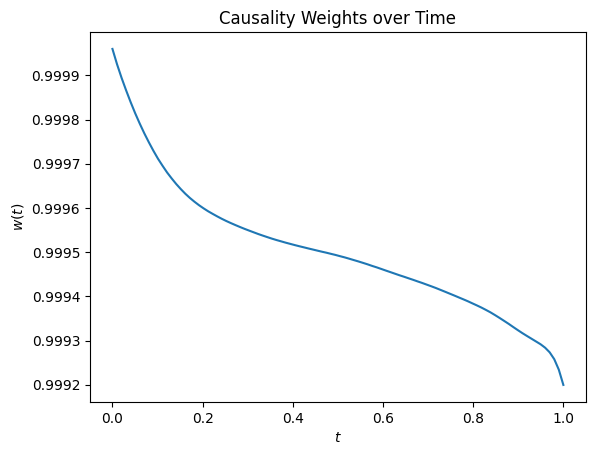

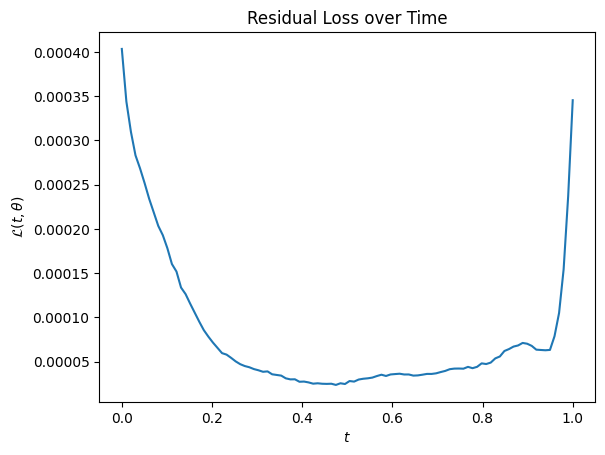

In [2]:
# Choose epsilon function and parameters
epsilon_func = epsilon_constant
epsilon_params = (0.1,)  # epsilon_value


# Initialize and train the model
model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, epsilon_func, epsilon_params)

# Train
model.train(nIter=n_iter)

# Plot loss curves
plt.figure()
plt.plot(model.loss_ics_log, label='Initial Condition Loss')
plt.plot(model.loss_res_log, label='Residual Loss')
plt.yscale('log')
plt.xlabel('Iterations (per 1000)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Get trained network parameters
params = model.get_params(model.opt_state)
u_pred = model.u_pred_fn(params, t_star, x_star)
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol)
print('Relative L2 error: {:.3e}'.format(error))

# Plot results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute Error')
plt.tight_layout()
plt.show()

# Plot snapshots at different time points
fig = plt.figure(figsize=(13, 4))
time_indices = [0, len(t_star)//2, -1]
time_labels = [t_star[0], t_star[len(t_star)//2], t_star[-1]]
for i, idx in enumerate(time_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(x_star, usol[:, idx], label='Exact', color='blue')
    plt.plot(x_star, u_pred[:, idx], '--', label='Predicted', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(x, t)$')
    plt.title(f'$t = {time_labels[i]:.2f}$')
    plt.legend()
    plt.tight_layout()
plt.show()

# Plot weights and cumulative loss over time
L_t, W = model.residuals_and_weights(params)
plt.figure()
plt.plot(model.t_r, W)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')
plt.title('Causality Weights over Time')
plt.show()

plt.figure()
plt.plot(model.t_r, L_t)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')
plt.title('Residual Loss over Time')
plt.show()


## Time-dependent 𝜖
Baseline from Wang

  0%|          | 0/300000 [00:00<?, ?it/s]

100%|██████████| 300000/300000 [07:03<00:00, 708.14it/s, Loss=0.0005256108, loss_ics=6.8925766e-07, loss_res=0.00050072686] 


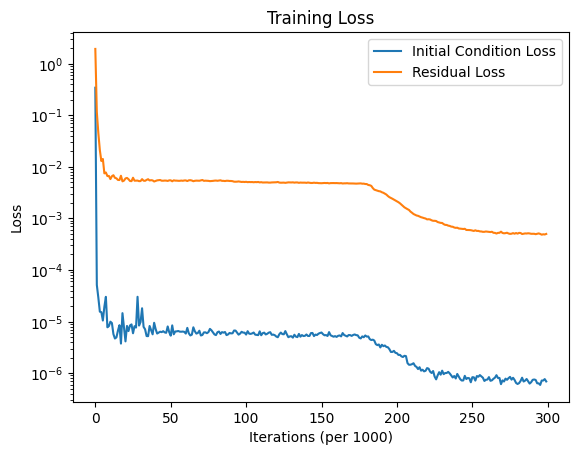

Relative L2 error: 2.400e-01


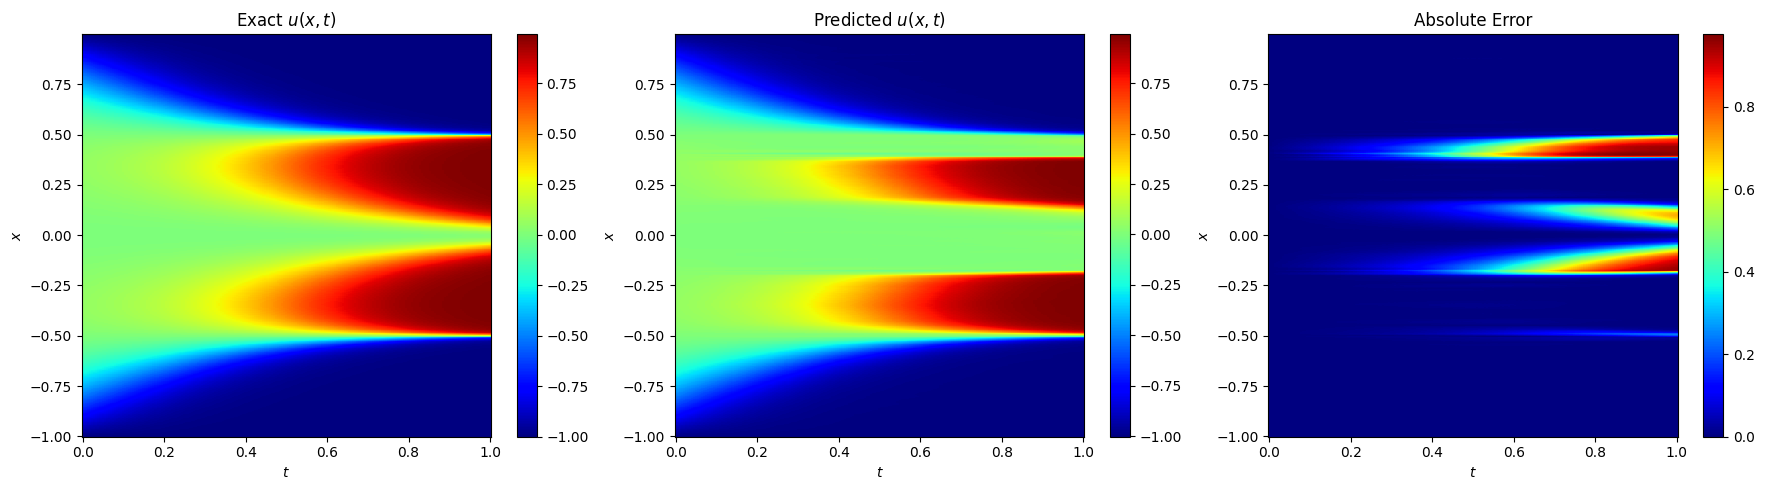

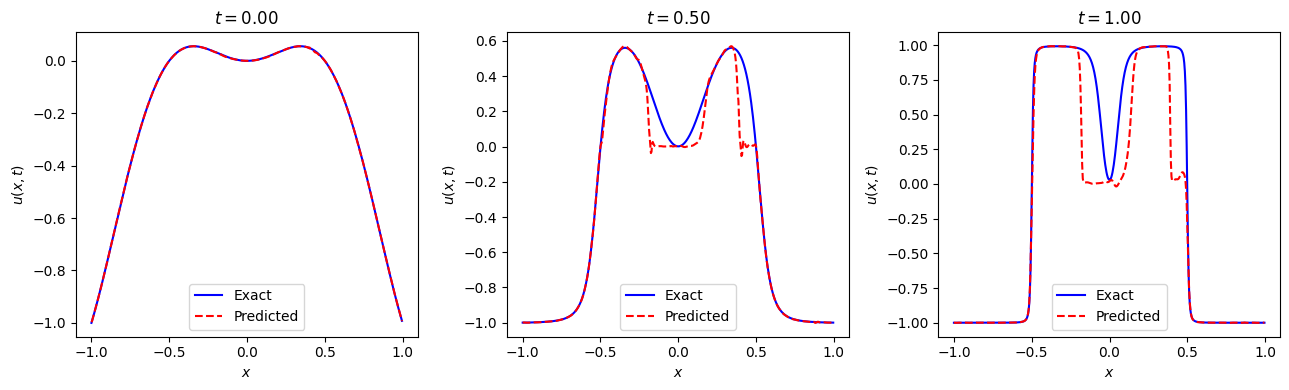

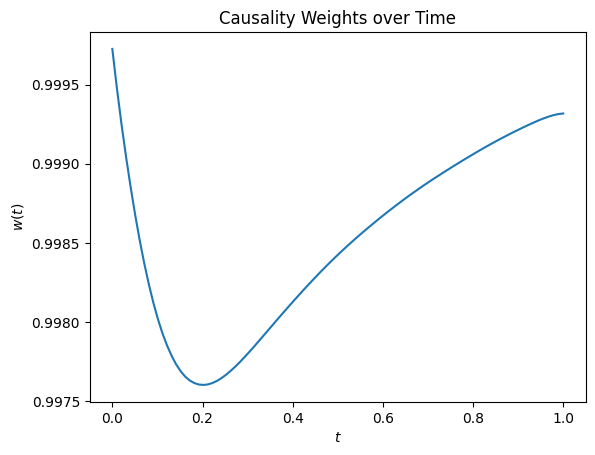

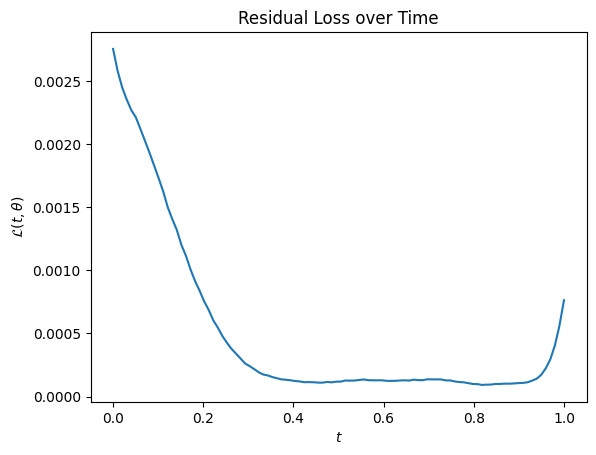

In [3]:

# Choose epsilon function and parameters
epsilon_func = epsilon_time_dependent
epsilon_params = (0.1, 2.0)  # epsilon_0, decay_rate


# Initialize and train the model
model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, epsilon_func, epsilon_params)

# Train
model.train(nIter=n_iter)

# Plot loss curves
plt.figure()
plt.plot(model.loss_ics_log, label='Initial Condition Loss')
plt.plot(model.loss_res_log, label='Residual Loss')
plt.yscale('log')
plt.xlabel('Iterations (per 1000)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Get trained network parameters
params = model.get_params(model.opt_state)
u_pred = model.u_pred_fn(params, t_star, x_star)
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol)
print('Relative L2 error: {:.3e}'.format(error))

# Plot results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute Error')
plt.tight_layout()
plt.show()

# Plot snapshots at different time points
fig = plt.figure(figsize=(13, 4))
time_indices = [0, len(t_star)//2, -1]
time_labels = [t_star[0], t_star[len(t_star)//2], t_star[-1]]
for i, idx in enumerate(time_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(x_star, usol[:, idx], label='Exact', color='blue')
    plt.plot(x_star, u_pred[:, idx], '--', label='Predicted', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(x, t)$')
    plt.title(f'$t = {time_labels[i]:.2f}$')
    plt.legend()
    plt.tight_layout()
plt.show()

# Plot weights and cumulative loss over time
L_t, W = model.residuals_and_weights(params)
plt.figure()
plt.plot(model.t_r, W)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')
plt.title('Causality Weights over Time')
plt.show()

plt.figure()
plt.plot(model.t_r, L_t)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')
plt.title('Residual Loss over Time')
plt.show()


## Residual 𝜖

  0%|          | 0/300000 [00:00<?, ?it/s]

100%|██████████| 300000/300000 [07:05<00:00, 705.74it/s, Loss=0.00047568805, loss_ics=6.478522e-07, loss_res=0.00044392064] 


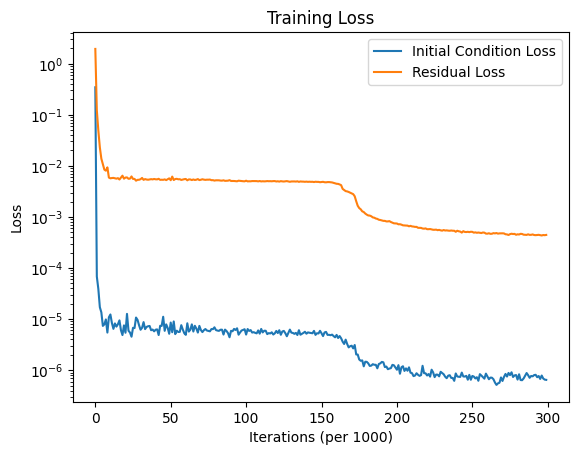

Relative L2 error: 2.109e-01


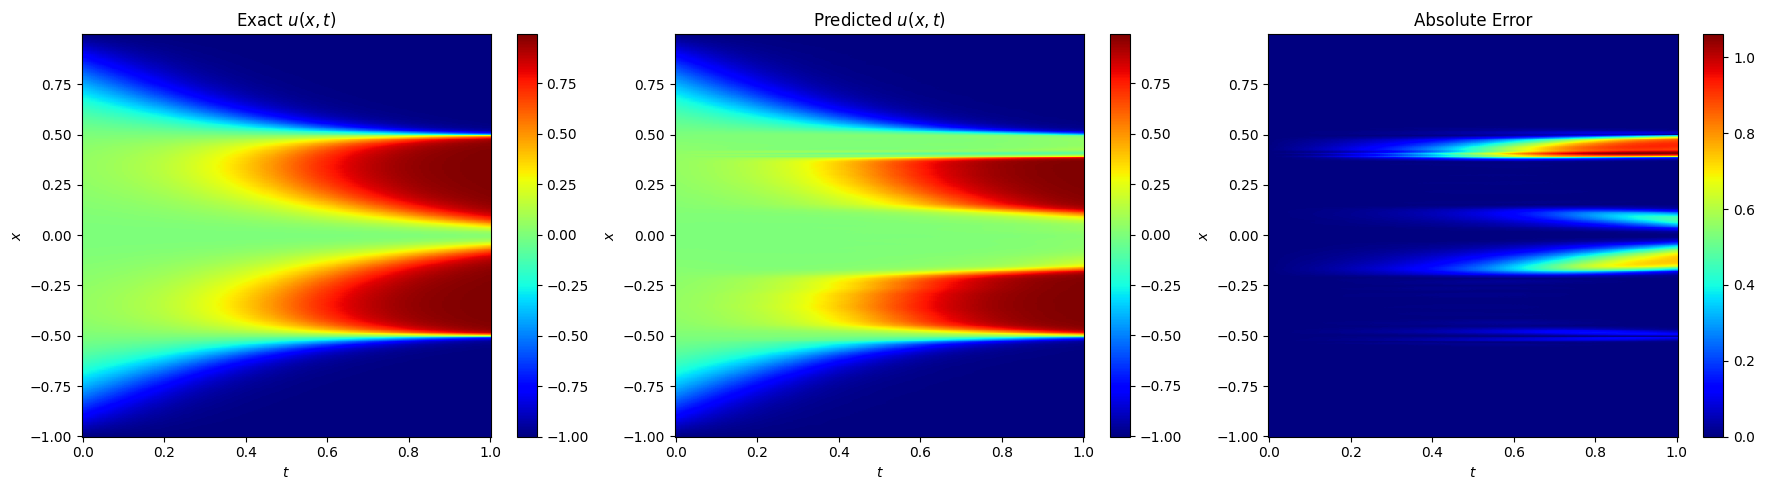

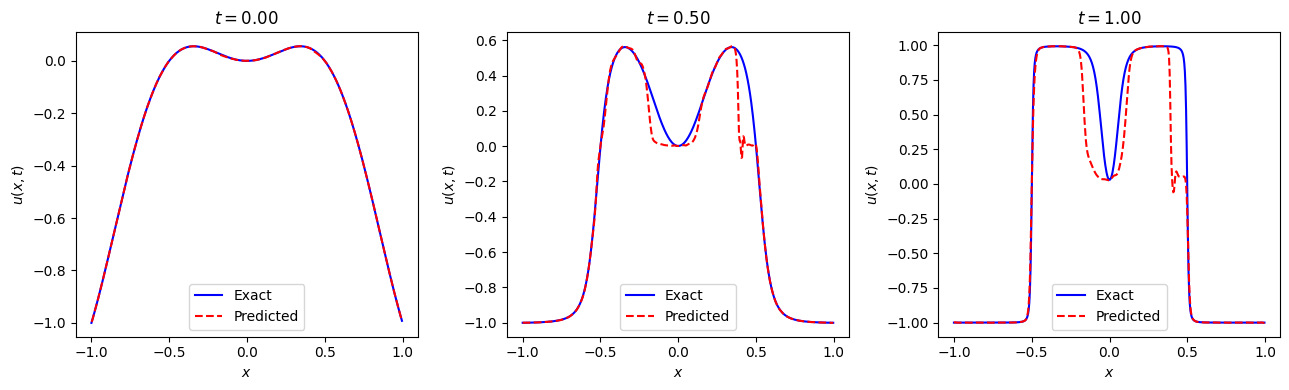

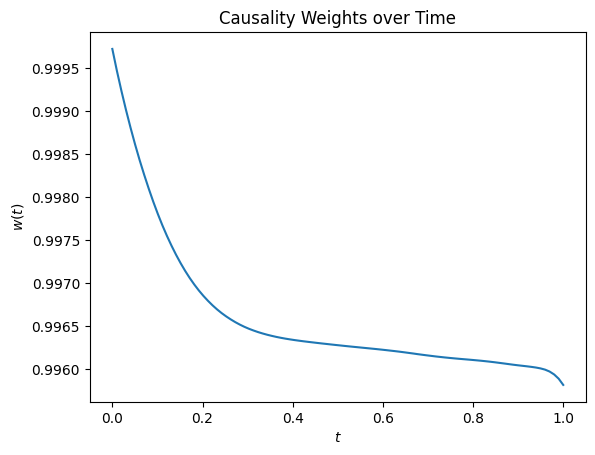

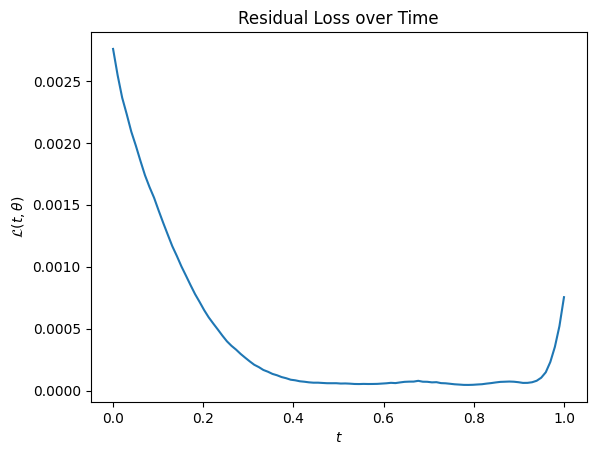

In [4]:
# Choose epsilon function and parameters
epsilon_func = epsilon_residual_based
epsilon_params = (0.1, 0.5)  # alpha_param, lambda_param

# Initialize and train the model
model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, epsilon_func, epsilon_params)

# Train
model.train(nIter=n_iter)

# Plot loss curves
plt.figure()
plt.plot(model.loss_ics_log, label='Initial Condition Loss')
plt.plot(model.loss_res_log, label='Residual Loss')
plt.yscale('log')
plt.xlabel('Iterations (per 1000)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Get trained network parameters
params = model.get_params(model.opt_state)
u_pred = model.u_pred_fn(params, t_star, x_star)
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol)
print('Relative L2 error: {:.3e}'.format(error))

# Plot results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute Error')
plt.tight_layout()
plt.show()

# Plot snapshots at different time points
fig = plt.figure(figsize=(13, 4))
time_indices = [0, len(t_star)//2, -1]
time_labels = [t_star[0], t_star[len(t_star)//2], t_star[-1]]
for i, idx in enumerate(time_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(x_star, usol[:, idx], label='Exact', color='blue')
    plt.plot(x_star, u_pred[:, idx], '--', label='Predicted', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(x, t)$')
    plt.title(f'$t = {time_labels[i]:.2f}$')
    plt.legend()
    plt.tight_layout()
plt.show()

# Plot weights and cumulative loss over time
L_t, W = model.residuals_and_weights(params)
plt.figure()
plt.plot(model.t_r, W)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')
plt.title('Causality Weights over Time')
plt.show()

plt.figure()
plt.plot(model.t_r, L_t)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')
plt.title('Residual Loss over Time')
plt.show()


## Gradient-based 

100%|██████████| 300000/300000 [08:00<00:00, 624.07it/s, Loss=5.2430078e-05, loss_ics=4.058147e-07, loss_res=5.003345e-05]    


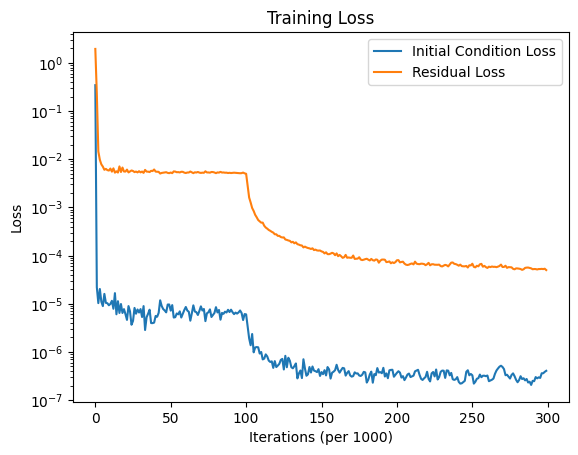

Relative L2 error: 7.181e-02


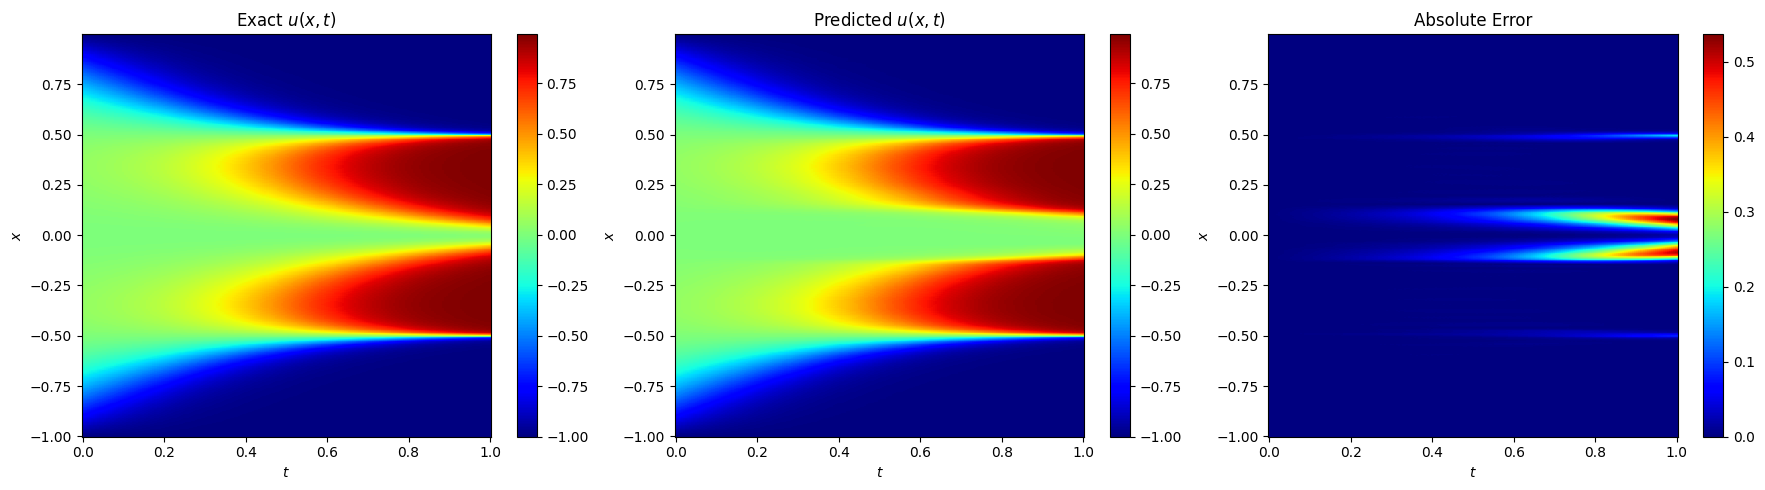

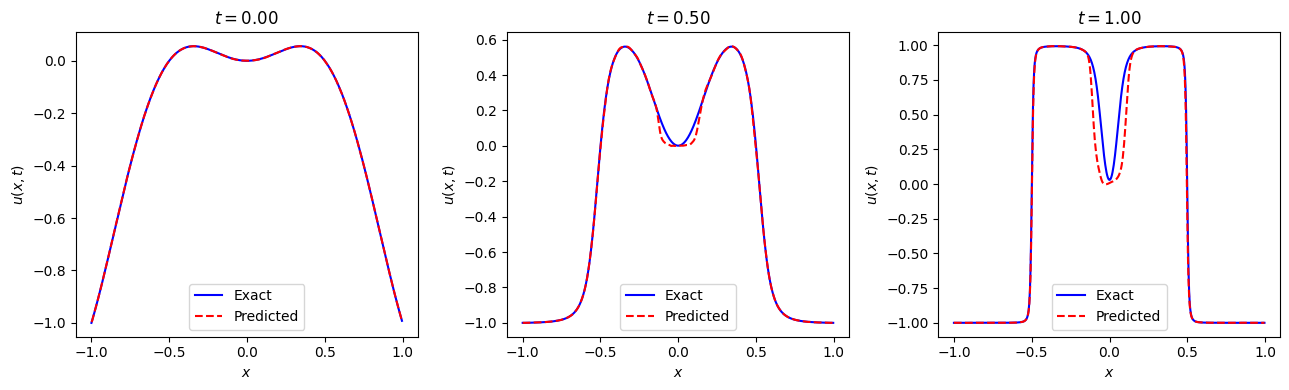

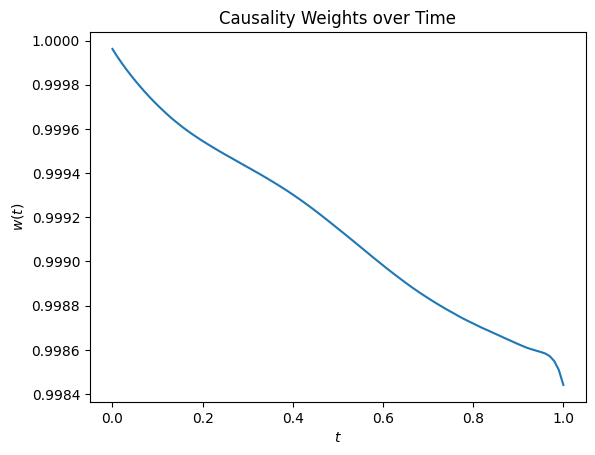

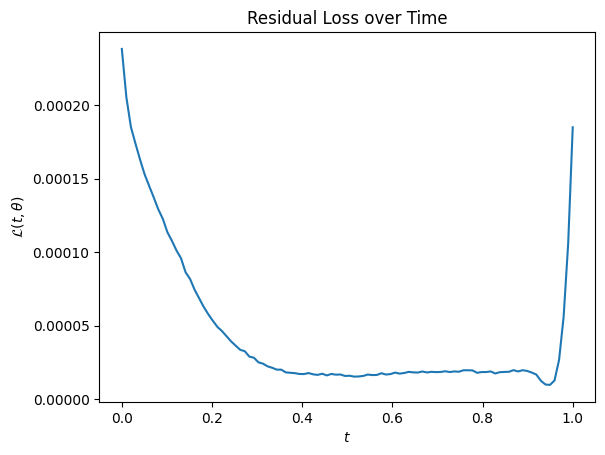

In [5]:

# Choose epsilon function and parameters
epsilon_func = epsilon_gradient_based
epsilon_params = (0.1, 0.05)  # alpha_param, beta_param

# Initialize and train the model
model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, epsilon_func, epsilon_params)

# Train
model.train(nIter=n_iter)


# Plot loss curves
plt.figure()
plt.plot(model.loss_ics_log, label='Initial Condition Loss')
plt.plot(model.loss_res_log, label='Residual Loss')
plt.yscale('log')
plt.xlabel('Iterations (per 1000)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Get trained network parameters
params = model.get_params(model.opt_state)
u_pred = model.u_pred_fn(params, t_star, x_star)
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol)
print('Relative L2 error: {:.3e}'.format(error))

# Plot results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted $u(x, t)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute Error')
plt.tight_layout()
plt.show()

# Plot snapshots at different time points
fig = plt.figure(figsize=(13, 4))
time_indices = [0, len(t_star)//2, -1]
time_labels = [t_star[0], t_star[len(t_star)//2], t_star[-1]]
for i, idx in enumerate(time_indices):
    plt.subplot(1, 3, i+1)
    plt.plot(x_star, usol[:, idx], label='Exact', color='blue')
    plt.plot(x_star, u_pred[:, idx], '--', label='Predicted', color='red')
    plt.xlabel('$x$')
    plt.ylabel('$u(x, t)$')
    plt.title(f'$t = {time_labels[i]:.2f}$')
    plt.legend()
    plt.tight_layout()
plt.show()

# Plot weights and cumulative loss over time
L_t, W = model.residuals_and_weights(params)
plt.figure()
plt.plot(model.t_r, W)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')
plt.title('Causality Weights over Time')
plt.show()

plt.figure()
plt.plot(model.t_r, L_t)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')
plt.title('Residual Loss over Time')
plt.show()


## Results
Relative $L_2$ error:
- Constant: 8.392e-02
- Time-dependent: 2.400e-01
- Residual: 2.109e-01
- Gradient-based: 7.181e-02

# MambaForGCN

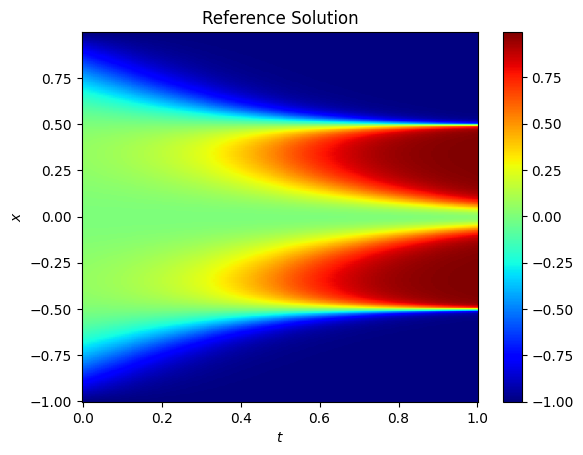

100%|██████████| 30000/30000 [07:57<00:00, 62.78it/s, Loss=9.988534e-05, loss_ics=5.56086e-07, loss_res=5.2581872e-05]    


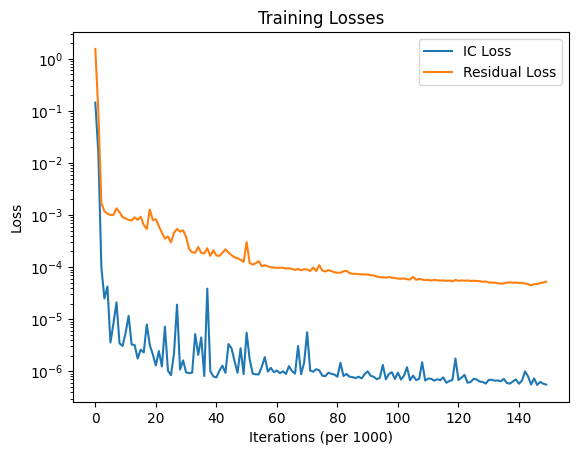

Relative L2 error: 9.935e-01


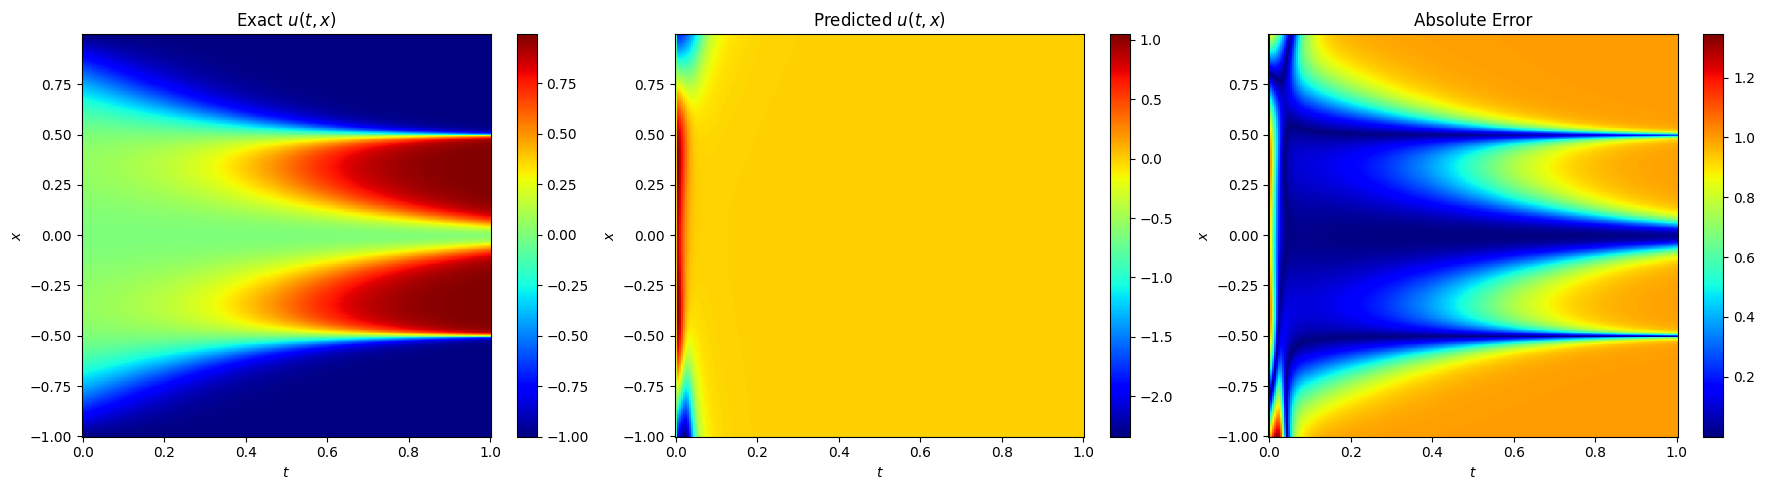

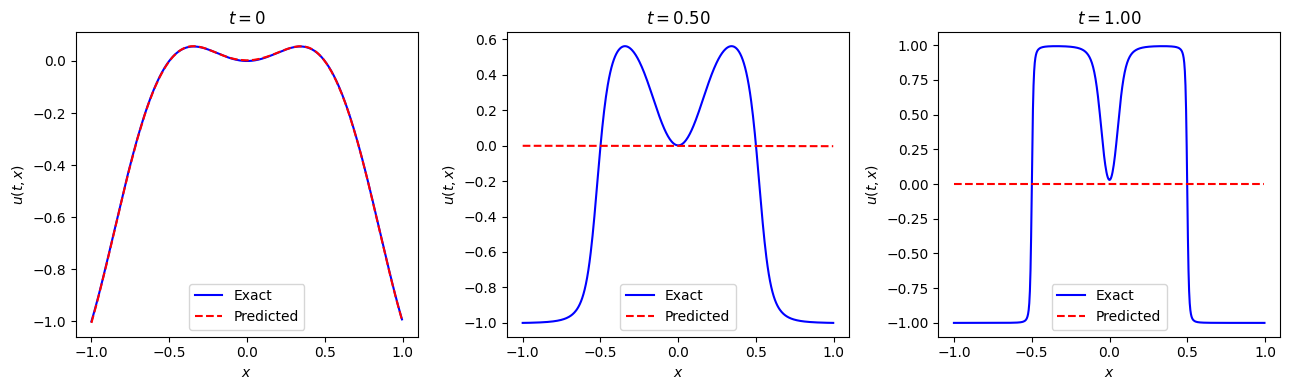

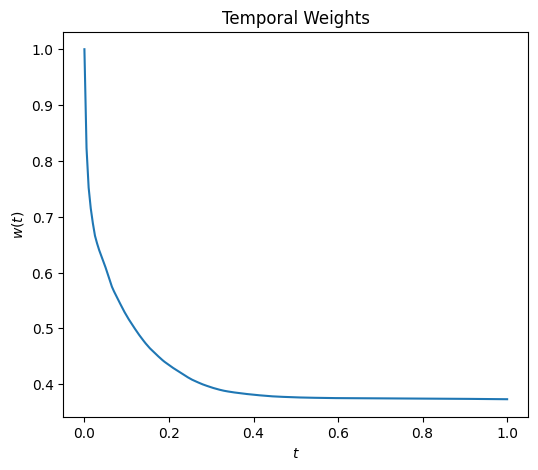

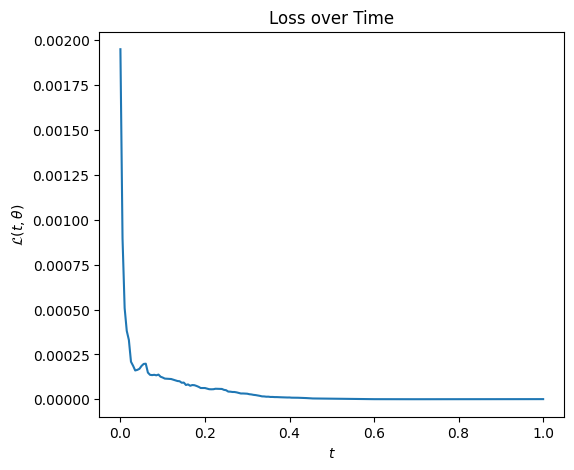

In [1]:
import numpy as onp
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax import lax

import itertools
from functools import partial
from tqdm import trange

import scipy.io
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

# Import Flax modules
import flax.linen as nn
from flax.training import train_state

# Define SynGCN Layer
class SynGCN(nn.Module):
    output_dim: int

    @nn.compact
    def __call__(self, h, adjacency_matrix):
        W = self.param('W', nn.initializers.xavier_uniform(), (h.shape[-1], self.output_dim))
        h_transformed = h @ W  # Shape: (batch_size, seq_len, output_dim)
        h_next = jax.nn.relu(jnp.einsum('bnm,bmd->bnd', adjacency_matrix, h_transformed))
        return h_next

# Define Multi-Head Attention (MHA) Layer
class MultiHeadAttention(nn.Module):
    num_heads: int
    head_dim: int

    @nn.compact
    def __call__(self, x):
        batch_size, seq_len, _ = x.shape
        projection_dim = self.num_heads * self.head_dim

        # Linear projections
        proj_q = nn.Dense(projection_dim)(x)
        proj_k = nn.Dense(projection_dim)(x)
        proj_v = nn.Dense(projection_dim)(x)
        out_proj = nn.Dense(projection_dim)

        # Reshape and transpose for multi-head attention
        Q = proj_q.reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        K = proj_k.reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        V = proj_v.reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)

        # Scaled dot-product attention
        scores = jnp.einsum('bhqd,bhkd->bhqk', Q, K) / jnp.sqrt(self.head_dim)
        attn_weights = nn.softmax(scores, axis=-1)
        attended_values = jnp.einsum('bhqk,bhkd->bhqd', attn_weights, V)

        # Concatenate heads
        attended_values = attended_values.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, projection_dim)
        return out_proj(attended_values)

# Define Mamba Block for Long-Range Dependency with matching hidden dimension
class MambaBlock(nn.Module):
    hidden_dim: int  # This should match num_heads * head_dim in MambaForGCN

    @nn.compact
    def __call__(self, x):
        conv_proj = nn.Conv(self.hidden_dim, (1,))(x)
        gated_output = conv_proj * nn.sigmoid(conv_proj)
        return nn.LayerNorm()(gated_output + x)

# Define KAN Gated Fusion Module with dimension alignment
class KANGatedFusion(nn.Module):
    output_dim: int  # Specify target output dimension

    @nn.compact
    def __call__(self, syn_gcn_out, mambaformer_out):
        # Project mambaformer_out to match syn_gcn_out dimensions
        mambaformer_out_proj = nn.Dense(self.output_dim)(mambaformer_out)
        
        # Compute gated fusion
        gate_syn = nn.sigmoid(nn.Dense(1)(syn_gcn_out))
        gate_mamba = nn.sigmoid(nn.Dense(1)(mambaformer_out_proj))
        
        # Combine with gating
        fused = gate_syn * syn_gcn_out + (1 - gate_syn) * gate_mamba * mambaformer_out_proj
        return fused

# Define MambaForGCN Architecture with updated KAN Gated Fusion
class MambaForGCN(nn.Module):
    num_heads: int
    head_dim: int
    hidden_dim: int  # Set this to match syn_gcn_out dimensions
    num_classes: int = 1  # Output dimension is 1 for u(t, x)

    def setup(self):
        self.syn_gcn = SynGCN(self.hidden_dim)
        self.mha = MultiHeadAttention(self.num_heads, self.head_dim)
        self.mamba_block = MambaBlock(self.num_heads * self.head_dim)  # Ensure matching dimensions
        self.kan_gated_fusion = KANGatedFusion(self.hidden_dim)  # Set target dimension for fusion
        self.classifier = nn.Dense(self.num_classes)

    def __call__(self, inputs, adjacency_matrix):
        # SynGCN for syntactic information
        syn_gcn_out = self.syn_gcn(inputs, adjacency_matrix)

        # MambaFormer for semantic representation
        mha_out = self.mha(inputs)
        mamba_out = self.mamba_block(mha_out)
        mambaformer_out = mha_out + mamba_out

        # KAN Gated Fusion for final integrated representation
        fused_out = self.kan_gated_fusion(syn_gcn_out, mambaformer_out)
        
        # Output layer
        logits = self.classifier(fused_out)  # Shape: (batch_size, seq_len, 1)
        return logits

# Define the PINN class with MambaForGCN integration
class PINN:
    def __init__(self, key, state0, t_star, x_star, tol):  

        # collocation points
        self.t_r = t_star  # Use t_star from data
        self.x_r = x_star  # Use x_star from data

        n_t = len(self.t_r)
        n_x = len(self.x_r)
        
        # For computing the temporal weights
        self.M = jnp.triu(jnp.ones((n_t, n_t)), k=1).T
        self.tol = tol

        # IC
        t_ic = jnp.zeros((state0.shape[0], 1))
        x_ic = x_star.reshape(-1, 1)
        self.X_ic = jnp.hstack([t_ic, x_ic])
        self.Y_ic = state0

        # Build adjacency matrix
        def build_adjacency_matrix(n_x):
            adjacency = jnp.eye(n_x)
            adjacency = adjacency.at[:-1, 1:].set(1)
            adjacency = adjacency.at[1:, :-1].set(1)
            return adjacency

        self.adjacency_matrix = build_adjacency_matrix(n_x)
        self.adjacency_matrix = self.adjacency_matrix[None, :, :]  # Add batch dimension

        # Initialize the MambaForGCN model
        num_heads = 4
        head_dim = 8
        hidden_dim = 64

        self.model = MambaForGCN(
            num_heads=num_heads,
            head_dim=head_dim,
            hidden_dim=hidden_dim,
            num_classes=1
        )

        # Prepare initial inputs for parameter initialization
        batch_size = 1
        seq_len = self.x_r.shape[0]
        feature_dim = 2  # Since we're using [t, x] as features
        inputs = jnp.stack([jnp.full(seq_len, self.t_r[0]), self.x_r], axis=-1)  # Shape: (seq_len, 2)
        inputs = inputs[None, :, :]  # Add batch dimension

        # Initialize parameters
        params = self.model.init(key, inputs, self.adjacency_matrix)
        _, self.unravel = ravel_pytree(params)
        self.params = params

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params) 

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []
    
    def neural_net(self, params, t, x):
        # Ensure t and x are arrays
        t = jnp.atleast_1d(t)
        x = jnp.atleast_1d(x)
        seq_len = x.shape[0]
        t_array = jnp.full(seq_len, t[0]) if t.size == 1 else t
        node_features = jnp.stack([t_array, x], axis=-1)  # Shape: (seq_len, 2)
        node_features = node_features[None, :, :]  # Add batch dimension: (1, seq_len, 2)

        # Adjust adjacency_matrix
        if seq_len == self.adjacency_matrix.shape[1]:
            adjacency_matrix = self.adjacency_matrix
        else:
            adjacency_matrix = jnp.eye(seq_len)[None, :, :]  # Shape: (1, seq_len, seq_len)

        outputs = self.model.apply(params, node_features, adjacency_matrix)

        result = outputs[0, :, 0]  # Shape: (seq_len,)

        # If the output is a single value, return it as a scalar
        if result.size == 1:
            return result[0]  # Return scalar
        else:
            return result  # Return array of shape (seq_len,)
    
    def residual_net(self, params, t, x):
        # x is array of shape (n_x,)
        # Vectorize over x
        def compute_residual(xi):
            u = self.neural_net(params, t, xi)
            u_t = grad(self.neural_net, argnums=1)(params, t, xi)
            u_x = grad(self.neural_net, argnums=2)(params, t, xi)
            u_xx = grad(grad(self.neural_net, argnums=2), argnums=2)(params, t, xi)
            return u_t + 5 * u**3 - 5 * u - nu * u_xx
        residuals = vmap(compute_residual)(x)
        return residuals

    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):
        # Compute residuals over the grid
        # Vectorize over t
        residuals_fn = lambda t: self.residual_net(params, t, self.x_r)
        r_pred = vmap(residuals_fn)(self.t_r)  # Shape: (n_t, n_x)
        L_t = jnp.mean(r_pred**2, axis=1)  # Mean over x
        W = lax.stop_gradient(jnp.exp(- tol * (self.M @ L_t)))
        return L_t, W

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params):
        # Evaluate the network over IC
        u_pred = self.neural_net(params, self.X_ic[:,0], self.X_ic[:,1])
        # Compute the initial loss
        loss_ics = jnp.mean((self.Y_ic.flatten() - u_pred.flatten())**2)
        return loss_ics

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params): 
        # Compute residuals over the grid
        residuals_fn = lambda t: self.residual_net(params, t, self.x_r)
        r_pred = vmap(residuals_fn)(self.t_r)
        # Compute loss
        loss_r = jnp.mean(r_pred**2)
        return loss_r  

    @partial(jit, static_argnums=(0,))  
    def loss(self, params):
        L0 = 100 * self.loss_ics(params)
        L_t, W = self.residuals_and_weights(params, self.tol)
        # Compute loss
        loss = jnp.mean(W * L_t) + L0
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):
        params = self.get_params(opt_state)
        loss_value, grads = jax.value_and_grad(self.loss)(params)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, loss_value

    # Optimize parameters in a loop
    def train(self, nIter = 10000):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_ics_value = self.loss_ics(params)
                loss_res_value = self.loss_res(params)
                L_t_value, W_value = self.residuals_and_weights(params, self.tol)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)
                self.W_log.append(W_value)
                self.L_t_log.append(L_t_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value, 
                                  'loss_res':  loss_res_value})

# Load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = jnp.meshgrid(t_star, x_star)

# Reference solution
plt.figure()
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Reference Solution')
plt.show()

# Create PINNs model
key = random.PRNGKey(1234)

# Hyper-parameters
nu = 0.0001
t0 = t_star[0]
t1 = t_star[-1]
# tol = 0.01

state0 = usol[:, 0:1]
tol = [0.1, 1.0, 10., 100.,]

state0 = usol[:, 0:1]

model = PINN(key, state0, t_star, x_star, 0.01)
model.train(nIter=30000)

for i in tol:
    model.tol = i
    model.train(nIter=30000)
# Plot Losses
plt.figure()
plt.plot(model.loss_ics_log, label='IC Loss')
plt.plot(model.loss_res_log, label='Residual Loss')
plt.yscale('log')
plt.xlabel('Iterations (per 1000)')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

# Get trained network parameters
params = model.get_params(model.opt_state)

# Evaluate the model
u_pred_list = []
for t in t_star:
    u_pred = model.neural_net(params, t, x_star)
    u_pred_list.append(u_pred)
u_pred = jnp.array(u_pred_list).T  # Shape should be (n_x, n_t)

# Compute error
error = jnp.linalg.norm(u_pred - usol) / jnp.linalg.norm(usol) 
print('Relative L2 error: {:.3e}'.format(error))

# Plot Results
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact $u(t, x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted $u(t, x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, jnp.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute Error')
plt.tight_layout()
plt.show()

# Plot Comparisons at Specific Times
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:,0], color='blue', label='Exact')
plt.plot(x_star, u_pred[:,0], '--', color='red', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0$')
plt.legend()
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:,len(t_star)//2], color='blue', label='Exact')
plt.plot(x_star, u_pred[:,len(t_star)//2], '--', color='red', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title(f'$t = {t_star[len(t_star)//2]:.2f}$')
plt.legend()
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:,-1], color='blue', label='Exact')
plt.plot(x_star, u_pred[:,-1], '--', color='red', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title(f'$t = {t_star[-1]:.2f}$')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Temporal Weights
L_t_value, W_value = model.residuals_and_weights(params, model.tol)
fig = plt.figure(figsize=(6, 5))
plt.plot(model.t_r, W_value)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')
plt.title('Temporal Weights')
plt.show()

fig = plt.figure(figsize=(6, 5))
plt.plot(model.t_r, L_t_value)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')
plt.title('Loss over Time')
plt.show()
